## Introduction: 
### Can a model learn to “see” an iNaturalist user’s hikes? <a id = "0"></a>

In this notebook, I explore this question via a case study by choosing a random user from the larger dataset, performing EDA and then applying models that attempt to identify clusters that correspond to a user's hikes.

My initial model doesn't not use machine learning but simply groups the data by individual dates and uses a "minimum sample" measure (just as DBSCAN does) to identify individual "hikes" and then "noise". I use visualization and silhouette scores to compare this non ML model's performance against DBSCAN.

I chose DBSCAN as the clustering algorithm for the following reasons:
1) The clusters I want to find are irregularly shaped, which DBSCAN is well-suited to finding compared to the other algortithms we've learned. 
2) The number of clusters (or "hikes") we are looking for varies with each user. This means DBSCAN is more likely to be able to build a "one-size-fits-all" model because it does not require "knowing" the number of clusters it is seeking, but finds that number based on the data, whereas the other algorithms we've learned require that information as input. 
3) The data I have includes "noise": one- and two- off observations that do not make a hike. Other algorithms we've learned seek to classify all data inside one of the clusters which would require me to allow those models to find a lot of "clusters" with only one observation, whereas DBSCAN is designed to identify clusters inside of noise, making it well-suited to this kind of modeling. 

Initial findings: Grouping by date does find activity that looks like hikes but also includes days of more "sporadic" observations that are not likely a single hike. I found that DBSCAN models can most certainly find these daily "hike" clusters and be more discerning about what a hike is than the blunt cut made by simply grouping by date. However, where it stands right now, the "best performing" DBSCAN models by silhouette score are too conservative with what is considered a cluster and cut out data points for clusters that are very likely part of the same hike.  




## Table of Contents <a id = "1"></a>

* [Intro](#0)
* [Imports and Data Intro](#2)
* [Feature Engineering Datetimes](#3)
* [Case Study: Random User 923056](#4)
    * [Bivariate EDA on Random_User](#5)
    * [Modeling -- Initial Exploration](#6)
    * [Exploratory DBSCAN](#7)
    * [Optimizing DBSCAN](#8)
    * [Visualizing Top Model(s)](#9)
    * [Data and Visualization for Sprint 2 Presentation](#10)
    


## Imports and Data Intro <a id = "2"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import random
import plotly.express as px

In [2]:
df_sp = pd.read_csv("../../data/spicata_clean_500.csv")
df_sp.head()

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4074931185.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sp = pd.read_csv("../../data/spicata_clean_500.csv")


Unnamed: 0        id                       observed_on_string observed_on  \
0           0    156253                      1990-09-01 20:20:16  1990-09-01   
1           1  99704839  Fri May 20 1994 09:37:00 GMT-0400 (EDT)  1994-05-20   
2           2  99705133  Fri May 20 1994 09:37:00 GMT-0400 (EDT)  1994-05-20   
3           3    160735  Thu May 20 1994 15:27:35 GMT-0400 (EDT)  1994-05-20   
4           4  36335283  Wed Jul 28 1999 08:24:34 GMT-0400 (EDT)  1999-07-28   

            time_observed_at                   time_zone  user_id  \
0  1990-09-02 00:20:16+00:00  Eastern Time (US & Canada)      317   
1  1994-05-20 13:37:00+00:00  Eastern Time (US & Canada)      317   
2  1994-05-20 13:37:00+00:00  Eastern Time (US & Canada)      317   
3  1994-05-20 19:27:35+00:00  Eastern Time (US & Canada)      317   
4  1999-07-28 12:24:34+00:00  Eastern Time (US & Canada)      317   

                  created_at quality_grade  \
0  2012-12-03 02:52:30+00:00      research   
1  2021-10-29 13:45:37+00:00      research   
2  2021-10-29 13:49:59+00:00      research   
3  2012-12-11 20:23:37+00:00      research   
4  2019-12-04 01:50:03+00:00      research   

                                                 url  ...  \
0     http://www.inaturalist.org/observations/156253  ...   
1  https://www.inaturalist.org/observations/99704839  ...   
2  https://www.inaturalist.org/observations/99705133  ...   
3     http://www.inaturalist.org/observations/160735  ...   
4  https://www.inaturalist.org/observations/36335283  ...   

           species_guess          scientific_name            common_name  \
0            Cururu Toad        Rhinella diptycha            Cururu Toad   
1   Brown-headed Cowbird           Molothrus ater   Brown-headed Cowbird   
2      Northern Cardinal    Cardinalis cardinalis      Northern Cardinal   
3   Brown-headed Cowbird           Molothrus ater   Brown-headed Cowbird   
4  American Red Squirrel  Tamiasciurus hudsonicus  American Red Squirrel   

   taxon_kingdom_name  taxon_genus_name       taxon_species_name  \
0            Animalia          Rhinella        Rhinella diptycha   
1            Animalia         Molothrus           Molothrus ater   
2            Animalia        Cardinalis    Cardinalis cardinalis   
3            Animalia         Molothrus           Molothrus ater   
4            Animalia      Tamiasciurus  Tamiasciurus hudsonicus   

   geoprivacy_obscured  taxon_geoprivacy_obscured   minute_diff      km_diff  
0                    0                          0 -1.000000e-03    -0.001000  
1                    0                          0  1.953437e+06  7492.228775  
2                    0                          0  0.000000e+00     0.000000  
3                    0                          0  3.505833e+02     0.472500  
4                    0                          0  2.728377e+06    56.747939  

[5 rows x 30 columns]

In [3]:
# drop repeat index column
df_sp.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
# convert time objects to UTC datetimes
df_sp["time_observed_at"] = pd.to_datetime(df_sp["time_observed_at"], utc = True)
df_sp["created_at"] = pd.to_datetime(df_sp["created_at"], utc = True)

In [5]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050151 entries, 0 to 1050150
Data columns (total 29 columns):
 #   Column                            Non-Null Count    Dtype              
---  ------                            --------------    -----              
 0   id                                1050151 non-null  int64              
 1   observed_on_string                1050151 non-null  object             
 2   observed_on                       1050151 non-null  object             
 3   time_observed_at                  1050151 non-null  datetime64[ns, UTC]
 4   time_zone                         1050151 non-null  object             
 5   user_id                           1050151 non-null  int64              
 6   created_at                        1050151 non-null  datetime64[ns, UTC]
 7   quality_grade                     1050151 non-null  object             
 8   url                               1050151 non-null  object             
 9   image_url                         1

## Feature Engineering Datetimes <a id = "3"></a>

Datetimes don't work for models and many graphs. There are boundless ways to engineer the datetime for EDA and later modeling. For now, I am choosing two options:
1) Continuous: "time passed since" -- I am choosing the earliest time that occurs in the dataset (minimum value of "time_observed_at", setting it to zero and measuring the other times in minutes since that earliest time
2) Discrete values: Breaking the "time_observed_at" and "created_at" dates into a column for each of its discrete integer parts: Year, Month, Day, Hour (leaving out minutes, especially because I already have a column engineered from the original EDA that measures each observation for a user in minutes since their last observation)

### Continuous time columns -- "minutes since"

In [6]:
# Creates a column ("obs_time_conv_(minutes)") that measures all observation times in minutes 
#that have passed since first observation of dataset

min_time = df_sp["time_observed_at"].min() # finds first time_observed for dataset
time_since = df_sp["time_observed_at"] - min_time #calcs diff between time_observed for row and first time
time_obs_conv = round((time_since.dt.total_seconds()) / 60 , 2) # converts diff to minutes
df_sp.loc[:, "obs_time_conv_(minutes)"] = time_obs_conv # stores values in a new column

df_sp.sample(3) #sanity check


id                       observed_on_string observed_on  \
805622  177188914                      2023-08-07 11:20:31  2023-08-07   
220301   46320092  Sun May 17 2020 10:43:29 GMT-0400 (EDT)  2020-05-17   
160461  134570539                      2022-08-23 10:39:16  2022-08-23   

                time_observed_at                   time_zone  user_id  \
805622 2023-08-07 16:20:31+00:00  Central Time (US & Canada)  1518270   
220301 2020-05-17 14:43:29+00:00  Eastern Time (US & Canada)   138597   
160461 2022-08-23 15:39:16+00:00  Central Time (US & Canada)    35203   

                      created_at quality_grade  \
805622 2023-08-07 16:21:49+00:00      research   
220301 2020-05-18 00:28:49+00:00      needs_id   
160461 2022-09-11 13:16:46+00:00      needs_id   

                                                      url  \
805622  https://www.inaturalist.org/observations/17718...   
220301  https://www.inaturalist.org/observations/46320092   
160461  https://www.inaturalist.org/observations/13457...   

                                                image_url  ...  \
805622  https://static.inaturalist.org/photos/30813801...  ...   
220301  https://inaturalist-open-data.s3.amazonaws.com...  ...   
160461  https://inaturalist-open-data.s3.amazonaws.com...  ...   

                 scientific_name       common_name  taxon_kingdom_name  \
805622         Rudbeckia triloba  brown-eyed Susan             Plantae   
220301             Pleuroceridae        not stated            Animalia   
160461  Ranunculus pensylvanicus  Bristly Crowfoot             Plantae   

        taxon_genus_name        taxon_species_name  geoprivacy_obscured  \
805622         Rudbeckia         Rudbeckia triloba                    0   
220301        not stated                not stated                    0   
160461        Ranunculus  Ranunculus pensylvanicus                    0   

        taxon_geoprivacy_obscured  minute_diff   km_diff  \
805622                          0     6.083333  0.169567   
220301                          0    17.766667  1.207440   
160461                          0     1.866667  0.000000   

       obs_time_conv_(minutes)  
805622             41542162.52  
220301             39847185.48  
160461             41039561.27  

[3 rows x 30 columns]

In [7]:
# Creates a column ("created_at_conv_(minutes)") that measures all "created_at" times in minutes 
# that have passed since first observation of dataset

# uses "min_time" from above--all still measured from first observation time, otherwise same code 
time_since = df_sp["created_at"] - min_time 
created_at_conv = round((time_since.dt.total_seconds()) / 60 , 2) 
df_sp.loc[:, "created_at_conv_(minutes)"] = created_at_conv
df_sp.sample(3)

id                       observed_on_string observed_on  \
245911  105988831  Tue Feb 01 2022 10:30:13 GMT-0800 (PST)  2022-02-01   
850692   61335423  Wed Sep 30 2020 15:53:32 GMT-0500 (CDT)  2020-09-30   
382549  148020231                      2023-02-04 11:14:24  2023-02-04   

                time_observed_at time_zone  user_id                created_at  \
245911 2022-02-01 20:30:13+00:00    Hawaii   150454 2022-02-01 22:57:33+00:00   
850692 2020-10-01 01:53:32+00:00    Hawaii  1820997 2020-09-30 20:53:54+00:00   
382549 2023-02-04 10:14:24+00:00     Paris   320666 2023-02-04 14:49:08+00:00   

       quality_grade                                                url  \
245911      needs_id  https://www.inaturalist.org/observations/10598...   
850692      research  https://www.inaturalist.org/observations/61335423   
382549      research  https://www.inaturalist.org/observations/14802...   

                                                image_url  ...  \
245911  https://inaturalist-open-data.s3.amazonaws.com...  ...   
850692  https://static.inaturalist.org/photos/98137760...  ...   
382549  https://inaturalist-open-data.s3.amazonaws.com...  ...   

                      common_name  taxon_kingdom_name  taxon_genus_name  \
245911  currants and gooseberries             Plantae             Ribes   
850692          Western Honey Bee            Animalia              Apis   
382549           hard shield fern             Plantae       Polystichum   

           taxon_species_name  geoprivacy_obscured  taxon_geoprivacy_obscured  \
245911             not stated                    0                          0   
850692         Apis mellifera                    0                          0   
382549  Polystichum aculeatum                    0                          0   

        minute_diff   km_diff  obs_time_conv_(minutes)  \
245911     0.566667  0.008683              40747532.22   
850692  1834.233333  0.019720              40043695.53   
382549     0.983333  0.083597              41276836.40   

       created_at_conv_(minutes)  
245911               40747679.55  
850692               40043395.90  
382549               41277111.13  

[3 rows x 31 columns]

### Discrete time columns -- Year, Month, Day and Hour

In [8]:
# creating a separate dataframe for these values and then concatenating them
# using this method because it ran the fastest and didn't throw warnings 
# whereas other ways of storing these directly back into df_sp did

# creating empty dataframe to store converted columns
discrete_time_df = pd.DataFrame()

# creating discrete columns from observation times
discrete_time_df['obs_year'] = df_sp['time_observed_at'].dt.year
discrete_time_df['obs_month'] = df_sp['time_observed_at'].dt.month
discrete_time_df['obs_day'] = df_sp['time_observed_at'].dt.day
discrete_time_df['obs_hour'] = df_sp['time_observed_at'].dt.hour

# creating discrete columns from inat posting times
discrete_time_df['created_year'] = df_sp['created_at'].dt.year
discrete_time_df['created_month'] = df_sp['created_at'].dt.month
discrete_time_df['created_day'] = df_sp['created_at'].dt.day
discrete_time_df['created_hour'] = df_sp['created_at'].dt.hour

In [9]:
 df_sp = pd.concat([df_sp, discrete_time_df], axis = 1)

In [10]:
df_sp.sample(3)

id         observed_on_string observed_on  \
988101  121724190         2022/06/09 1:46 PM  2022-06-09   
390956  187420978         2023/09/21 3:43 PM  2023-09-21   
39948     1499552  2015-05-16 1:44:13 PM CDT  2015-05-16   

                time_observed_at                   time_zone  user_id  \
988101 2022-06-09 18:46:00+00:00  Central Time (US & Canada)  3162904   
390956 2023-09-21 13:43:00+00:00                    Pretoria   320666   
39948  2015-05-16 18:44:13+00:00  Central Time (US & Canada)      604   

                      created_at quality_grade  \
988101 2022-06-14 12:42:58+00:00      research   
390956 2023-10-13 22:18:52+00:00      research   
39948  2015-05-17 00:37:21+00:00      research   

                                                      url  \
988101  https://www.inaturalist.org/observations/12172...   
390956  https://www.inaturalist.org/observations/18742...   
39948     http://www.inaturalist.org/observations/1499552   

                                                image_url  ...  \
988101  https://static.inaturalist.org/photos/20601413...  ...   
390956  https://inaturalist-open-data.s3.amazonaws.com...  ...   
39948   https://static.inaturalist.org/photos/1857222/...  ...   

       obs_time_conv_(minutes)  created_at_conv_(minutes)  obs_year  \
988101             40931748.00                40938584.97      2022   
390956             41606805.00                41639000.87      2023   
39948              37215106.22                37215459.35      2015   

        obs_month  obs_day  obs_hour  created_year  created_month  \
988101          6        9        18          2022              6   
390956          9       21        13          2023             10   
39948           5       16        18          2015              5   

        created_day created_hour  
988101           14           12  
390956           13           22  
39948            17            0  

[3 rows x 39 columns]

# Case Study: Random User 923056 <a id = "4"></a>

To explore how finding a user's "hikes" works, I picked a user at random using the commented out code and then did an exploratory analysis of that user's data and how one might go about modeling the user's hikes. 
 


In [11]:
# Code for choosing random user
#users = df_sp["user_id"].unique()
#np.random.choice(users)

In [12]:
# slice of larger data related to this user
random_user = 923056
rand_user_df = df_sp[df_sp["user_id"] == random_user]
rand_user_df.reset_index(inplace = True, drop = True)
rand_user_df.sample(3)

id                       observed_on_string observed_on  \
79  29452421  Wed Jul 24 2019 11:39:17 GMT-0400 (EDT)  2019-07-24   
48  28244611  Fri Jul 05 2019 11:20:50 GMT-0400 (EDT)  2019-07-05   
70  29452097  Wed Jul 24 2019 10:34:44 GMT-0400 (EDT)  2019-07-24   

            time_observed_at                   time_zone  user_id  \
79 2019-07-24 15:39:17+00:00  Eastern Time (US & Canada)   923056   
48 2019-07-05 15:20:50+00:00  Eastern Time (US & Canada)   923056   
70 2019-07-24 14:34:44+00:00  Eastern Time (US & Canada)   923056   

                  created_at quality_grade  \
79 2019-07-24 16:59:55+00:00      needs_id   
48 2019-07-05 18:45:14+00:00      research   
70 2019-07-24 16:55:07+00:00      needs_id   

                                                  url  \
79  https://www.inaturalist.org/observations/29452421   
48  https://www.inaturalist.org/observations/28244611   
70  https://www.inaturalist.org/observations/29452097   

                                            image_url  ...  \
79  https://static.inaturalist.org/photos/45965309...  ...   
48  https://static.inaturalist.org/photos/44015507...  ...   
70  https://static.inaturalist.org/photos/45964899...  ...   

   obs_time_conv_(minutes)  created_at_conv_(minutes)  obs_year  obs_month  \
79             39418121.28                39418201.92      2019          7   
48             39390742.83                39390947.23      2019          7   
70             39418056.73                39418197.12      2019          7   

    obs_day  obs_hour  created_year  created_month  created_day created_hour  
79       24        15          2019              7           24           16  
48        5        15          2019              7            5           18  
70       24        14          2019              7           24           16  

[3 rows x 39 columns]

In [13]:
rand_user_df["time_zone"].value_counts()

Eastern Time (US & Canada)     135
Mountain Time (US & Canada)     67
Pacific Time (US & Canada)      20
Hawaii                           3
Name: time_zone, dtype: int64

For ease and due to time constraint, I chose to leave the timestamp in UTC. This will make my non ML model a little less reliable because I am grouping by day according to "UTC" rather than local time. However my goal here is not to develop the most reliable non ML model but rather use it as an approximation of clustering so I choose this shortcut because all I need is an approximation. UTC still allows DBSCAN to cluster by relative time which is what we're looking for. This means that interpretation of user behavior around "time of day" is not reliable but it isn't the focus of this project. If I were to find that the DBSCAN models were performing poorly, an option would be to re-engineer the times into local times to see if that is helpful.

## Bivariate EDA on Random User<a id = "5"></a>

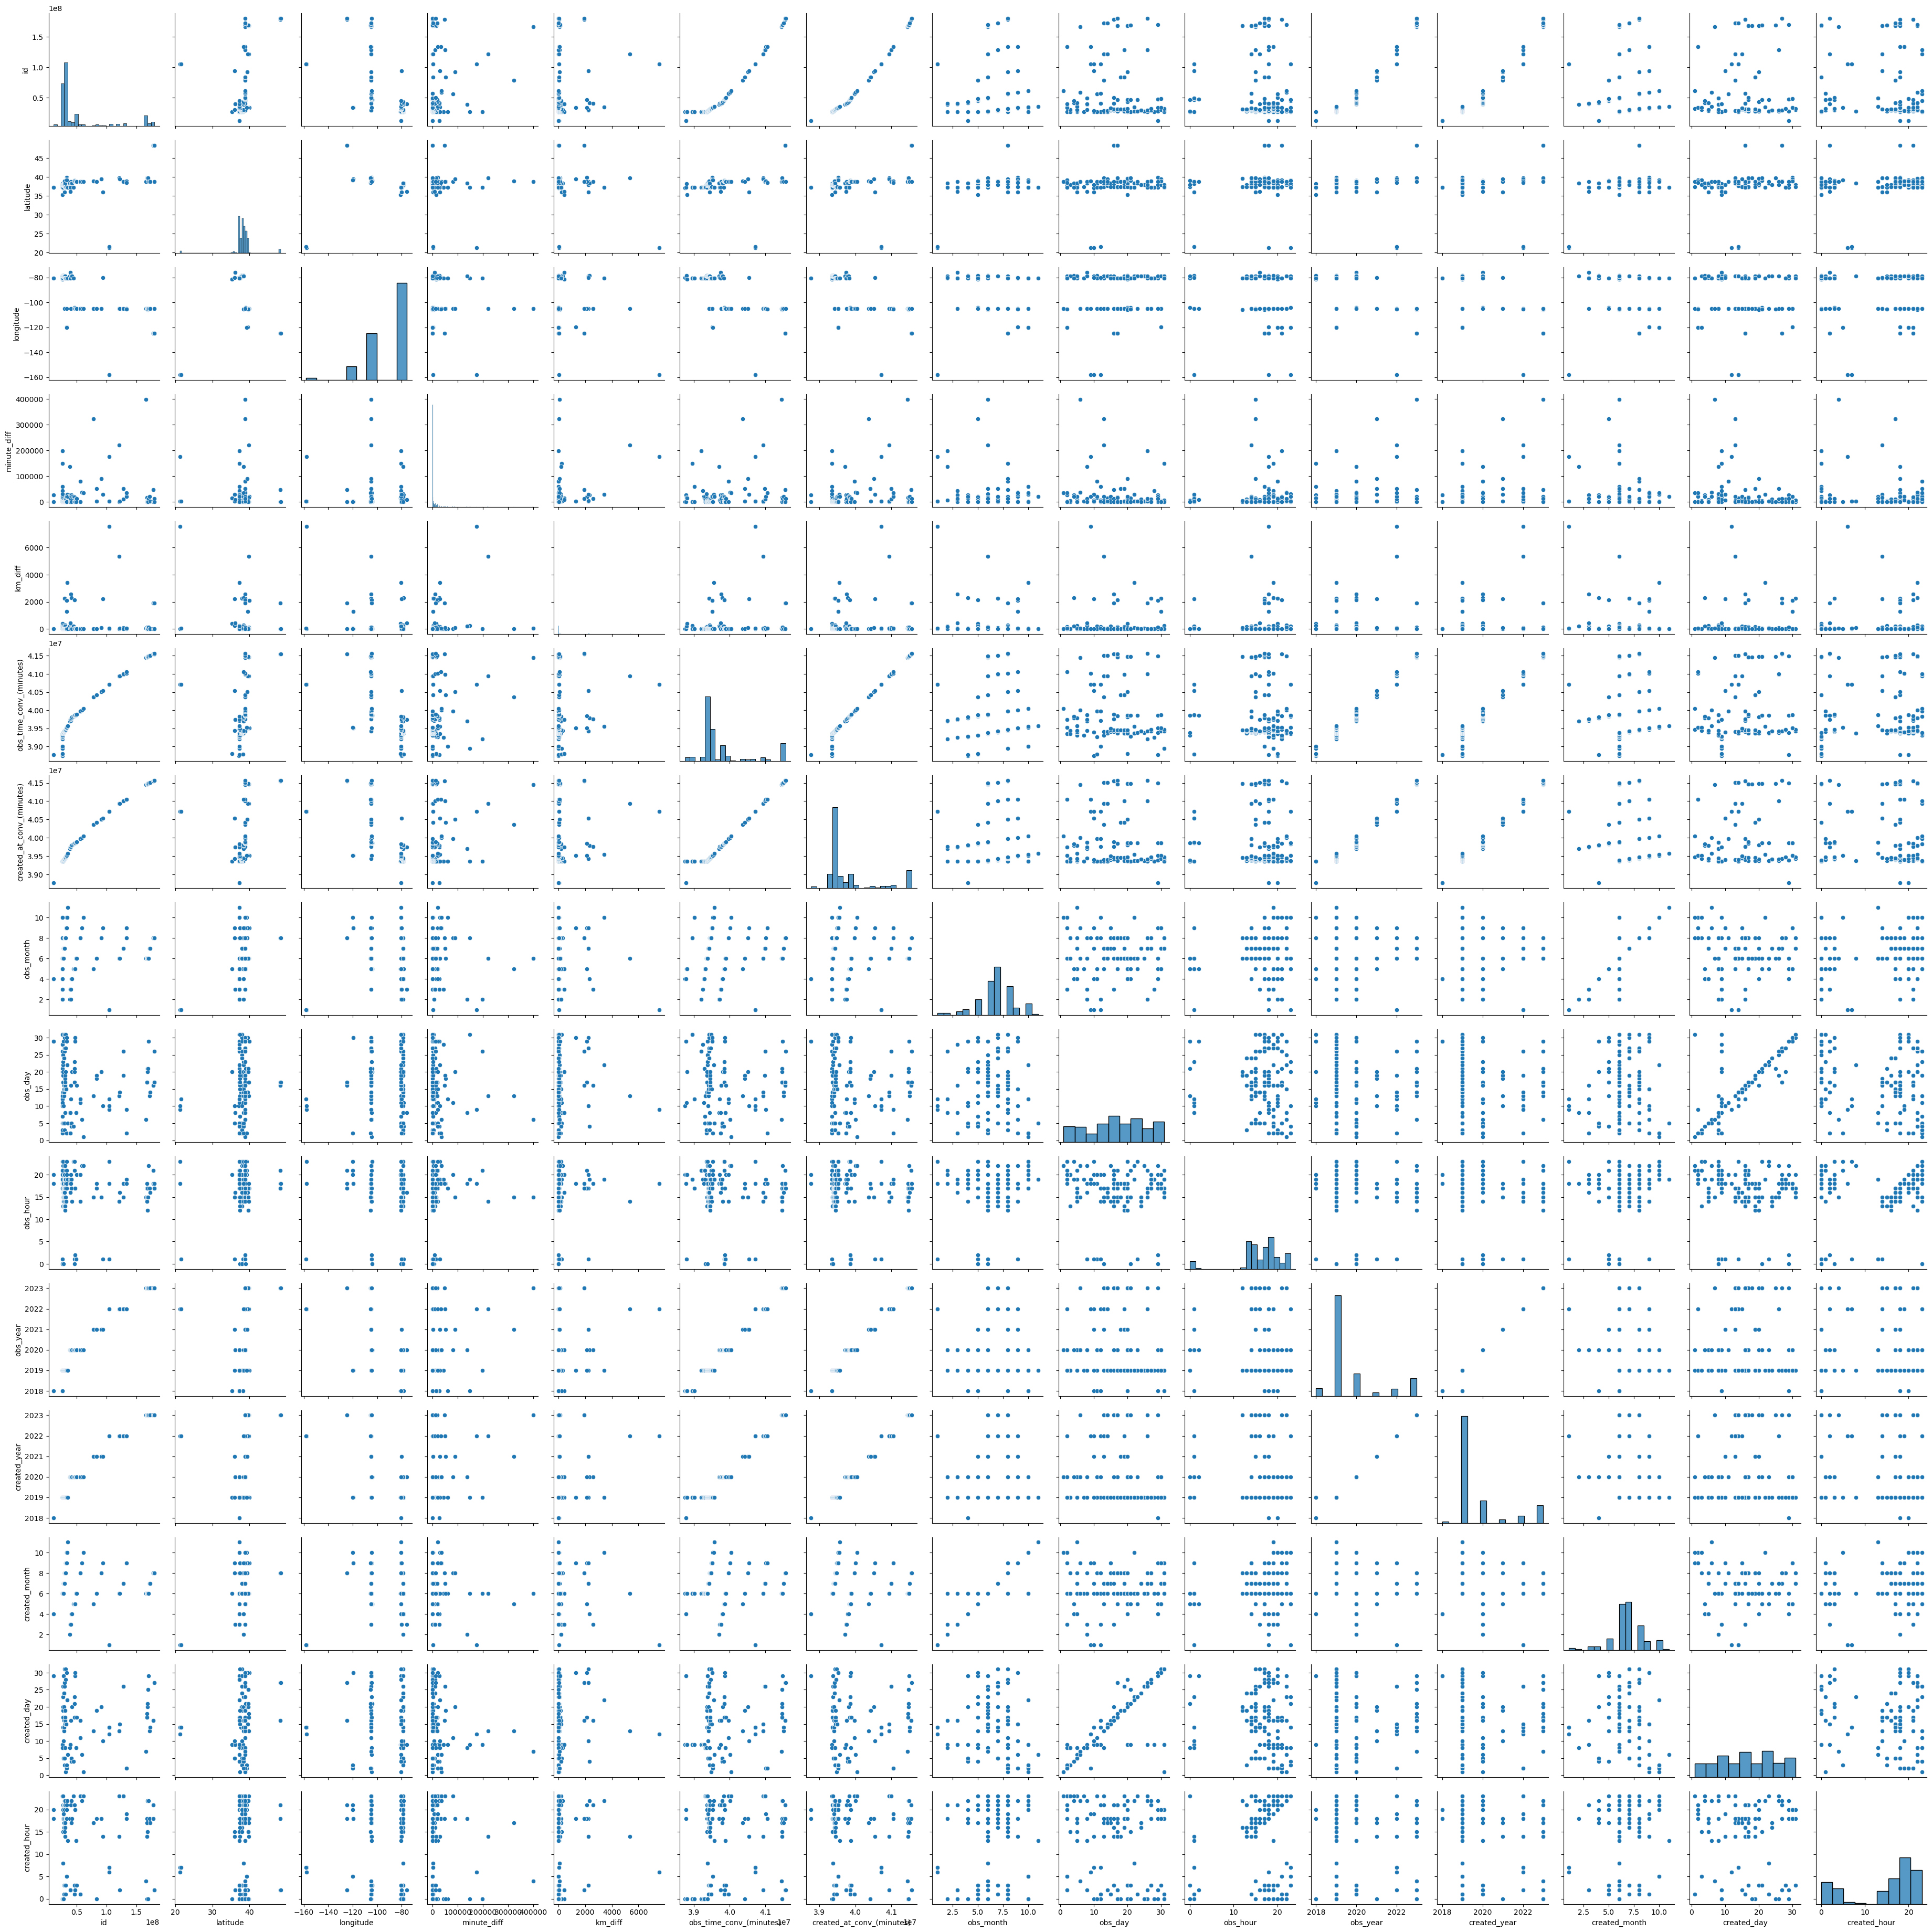

In [14]:
# choosing the columns I'm targeting for identifying geo/time clusters for "hikes"
pairplot_df = rand_user_df[['id', 'latitude',
       'longitude', 'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 'obs_month', 'obs_day', 'obs_hour', 'obs_year',
       'created_year', 'created_month', 'created_day', 'created_hour']]

sns.pairplot(pairplot_df)





The pairplot is mainly useful for reference if I end up having questions as I got through the analysis. It does generally confirms the multicolinearity of "id", "created_at" and "time_observed_at". 

For and overview user behavior over time and space, I've found that it is easiest to view latitude and longitude as separate scatterplots along the same time axis. This can be read with relative ease if the viewer understands that the longitude point corresponds directly with the latitude point above it.

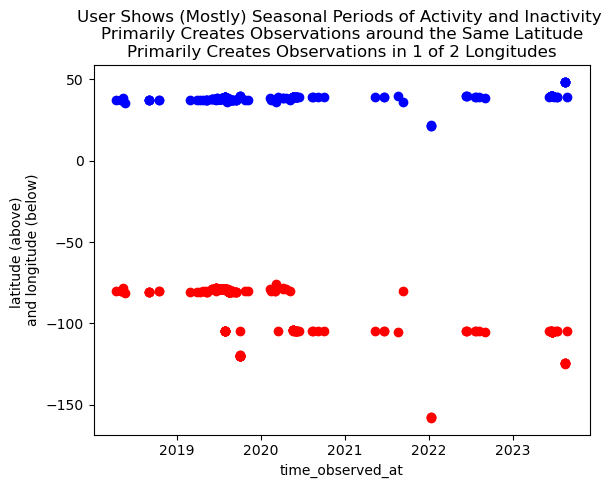

In [15]:
# User behavior over time and space


plt.figure()
plt.scatter(rand_user_df["time_observed_at"], rand_user_df["longitude"], c = 'red')
plt.scatter(rand_user_df["time_observed_at"], rand_user_df["latitude"], c = 'blue')
plt.xlabel("time_observed_at")
plt.ylabel("latitude (above) \nand longitude (below)")
plt.title("User Shows (Mostly) Seasonal Periods of Activity and Inactivity \nPrimarily Creates Observations around the Same Latitude\nPrimarily Creates Observations in 1 of 2 Longitudes")
plt.show()

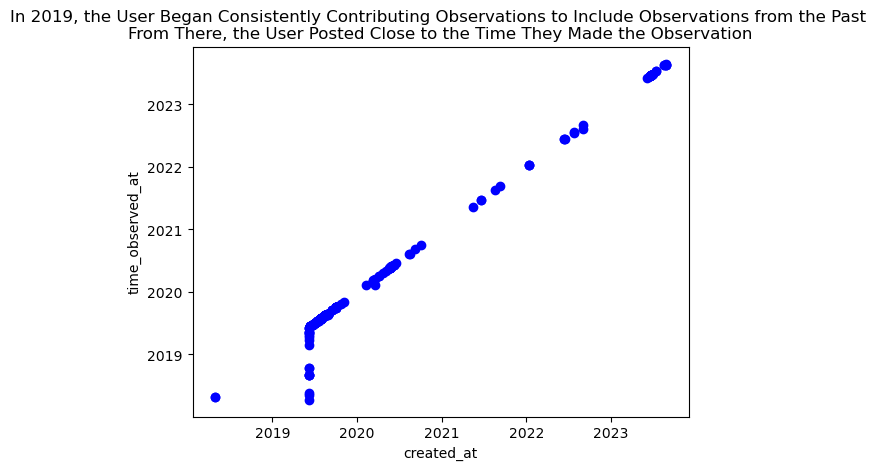

In [16]:
plt.figure()
plt.scatter(rand_user_df["created_at"], rand_user_df["time_observed_at"], c = 'blue')
plt.xlabel("created_at")
plt.ylabel("time_observed_at")
plt.title("In 2019, the User Began Consistently Contributing Observations to Include Observations from the Past \nFrom There, the User Posted Close to the Time They Made the Observation")
plt.show()

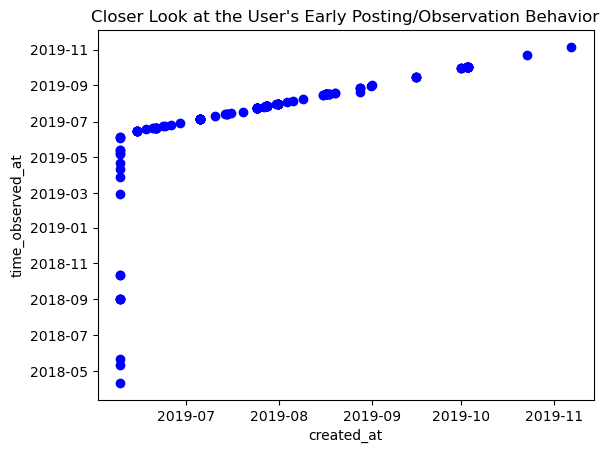

In [17]:
closer_look = rand_user_df[rand_user_df["created_at"].dt.strftime('%Y') == '2019']
plt.figure()
plt.scatter(closer_look["created_at"], closer_look["time_observed_at"], c = 'blue')
plt.xlabel("created_at")
plt.ylabel("time_observed_at")
plt.title("Closer Look at the User's Early Posting/Observation Behavior")
plt.show()

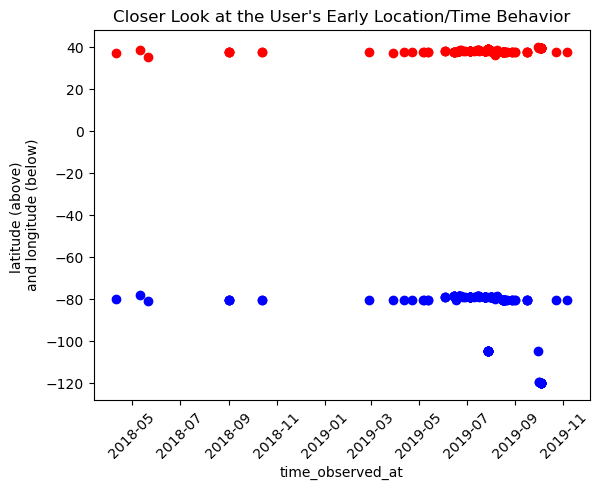

In [18]:
plt.figure()
plt.scatter(closer_look["time_observed_at"], closer_look["latitude"], c = 'red')
plt.scatter(closer_look["time_observed_at"], closer_look["longitude"], c = 'blue')
plt.xlabel("time_observed_at")
plt.ylabel("latitude (above) \nand longitude (below)")
plt.title("Closer Look at the User's Early Location/Time Behavior")
plt.xticks(rotation = 45)
plt.show()

In [19]:
closer_look.head()

id                       observed_on_string observed_on  \
0  26643807  Tue Apr 10 2018 16:18:13 GMT-0400 (EDT)  2018-04-10   
3  26643745  Thu May 10 2018 21:35:19 GMT-0400 (EDT)  2018-05-10   
4  26643675  Sun May 20 2018 16:03:39 GMT-0400 (EDT)  2018-05-20   
5  26643587  Fri Aug 31 2018 15:36:32 GMT-0400 (EDT)  2018-08-31   
6  26643040  Fri Aug 31 2018 15:37:17 GMT-0400 (EDT)  2018-08-31   

           time_observed_at                   time_zone  user_id  \
0 2018-04-10 20:18:13+00:00  Eastern Time (US & Canada)   923056   
3 2018-05-11 01:35:19+00:00  Eastern Time (US & Canada)   923056   
4 2018-05-20 20:03:39+00:00  Eastern Time (US & Canada)   923056   
5 2018-08-31 19:36:32+00:00  Eastern Time (US & Canada)   923056   
6 2018-08-31 19:37:17+00:00  Eastern Time (US & Canada)   923056   

                 created_at quality_grade  \
0 2019-06-09 00:25:55+00:00      research   
3 2019-06-09 00:25:08+00:00      research   
4 2019-06-09 00:24:27+00:00      research   
5 2019-06-09 00:23:04+00:00      needs_id   
6 2019-06-09 00:12:17+00:00      research   

                                                 url  \
0  https://www.inaturalist.org/observations/26643807   
3  https://www.inaturalist.org/observations/26643745   
4  https://www.inaturalist.org/observations/26643675   
5  https://www.inaturalist.org/observations/26643587   
6  https://www.inaturalist.org/observations/26643040   

                                           image_url  ...  \
0  https://static.inaturalist.org/photos/41383609...  ...   
3  https://static.inaturalist.org/photos/41383540...  ...   
4  https://static.inaturalist.org/photos/41383503...  ...   
5  https://static.inaturalist.org/photos/41383396...  ...   
6  https://static.inaturalist.org/photos/41382442...  ...   

  obs_time_conv_(minutes)  created_at_conv_(minutes)  obs_year  obs_month  \
0             38741600.22                39352407.92      2018          4   
3             38785117.32                39352407.13      2018          5   
4             38799185.65                39352406.45      2018          5   
5             38947478.53                39352405.07      2018          8   
6             38947479.28                39352394.28      2018          8   

   obs_day  obs_hour  created_year  created_month  created_day created_hour  
0       10        20          2019              6            9            0  
3       11         1          2019              6            9            0  
4       20        20          2019              6            9            0  
5       31        19          2019              6            9            0  
6       31        19          2019              6            9            0  

[5 rows x 39 columns]

In [20]:
# When user began contributing consistently on 06/09/19, how many observations did they upload?
(rand_user_df["created_at"].dt.strftime('%D') == '06/09/19').sum()

13

## Modeling -- Initial Exploration<a id = "6"></a>

### What can I find by just grouping by date?

Before trying complicated algorithms, a simple data analytics approach might choose to groupby date of observation time to approximate a "hike". I'll create clusters using this technique first and then compare to what emerges when I use clustering models.

In [21]:
# Use the date of time_observated_at to group and count rows
# Look at top 20 values when sorted lowest to highest
potential_hikes = rand_user_df["time_observed_at"].dt.strftime('%D').value_counts().sort_values().tail(20)
potential_hikes

08/17/23     3
06/08/20     3
08/27/19     3
06/20/23     3
07/14/19     3
08/17/19     4
05/30/20     4
08/31/18     4
09/15/19     4
06/17/23     6
06/20/19     6
06/21/23     6
05/20/20     6
06/14/19     6
07/31/19     9
08/16/19    10
07/27/19    11
10/02/19    12
07/05/19    14
07/24/19    21
Name: time_observed_at, dtype: int64

If I use 5 as a minimum for grouping, there are 11 "groups" here that might represent single hikes. Or 5 groups if I choose 10 or more as a grouping standard. 

In [22]:
# making an array of the dates with at least as many observations as the min_samples specified

min_samples = 10 # using same terminology as DBSCAN
top_dates = potential_hikes[potential_hikes.values >= min_samples].index
top_dates

Index(['08/16/19', '07/27/19', '10/02/19', '07/05/19', '07/24/19'], dtype='object')

In [23]:
# creating dictionary that will assign an integer to each cluster

artificial_cluster = {}
i = 0
for day in top_dates:
    artificial_cluster[day] = i
    i += 1
artificial_cluster
    

{'08/16/19': 0, '07/27/19': 1, '10/02/19': 2, '07/05/19': 3, '07/24/19': 4}

In [24]:
# Adding a cluster column to the dataframe

for i in range(rand_user_df.shape[0]):
    # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
    if rand_user_df.loc[i, "time_observed_at"].strftime('%D') in top_dates:
        rand_user_df.loc[i, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[i, "time_observed_at"].strftime('%D')]
    # otherwise, the new column will be assigned a -1 (the way DBSCAN does for noise)
    else:
        rand_user_df.loc[i, "Artif_Cluster"] = -1
rand_user_df.sample(3)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\3446309329.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df.loc[i, "Artif_Cluster"] = -1


id                       observed_on_string observed_on  \
148  33787038  Wed Oct 02 2019 16:24:08 GMT-0700 (PDT)  2019-10-02   
75   29452272  Wed Jul 24 2019 10:55:14 GMT-0400 (EDT)  2019-07-24   
96   29936664  Wed Jul 31 2019 12:12:40 GMT-0400 (EDT)  2019-07-31   

             time_observed_at                   time_zone  user_id  \
148 2019-10-02 23:24:08+00:00  Pacific Time (US & Canada)   923056   
75  2019-07-24 14:55:14+00:00  Eastern Time (US & Canada)   923056   
96  2019-07-31 16:12:40+00:00  Eastern Time (US & Canada)   923056   

                   created_at quality_grade  \
148 2019-10-03 05:53:42+00:00      research   
75  2019-07-24 16:57:40+00:00      research   
96  2019-07-31 20:05:54+00:00      research   

                                                   url  \
148  https://www.inaturalist.org/observations/33787038   
75   https://www.inaturalist.org/observations/29452272   
96   https://www.inaturalist.org/observations/29936664   

                                             image_url  ...  \
148  https://static.inaturalist.org/photos/53103154...  ...   
75   https://static.inaturalist.org/photos/45965084...  ...   
96   https://static.inaturalist.org/photos/46747788...  ...   

    created_at_conv_(minutes)  obs_year  obs_month  obs_day  obs_hour  \
148               39519775.70      2019         10        2        23   
75                39418199.67      2019          7       24        14   
96                39428467.90      2019          7       31        16   

     created_year  created_month  created_day  created_hour Artif_Cluster  
148          2019             10            3             5           2.0  
75           2019              7           24            16           4.0  
96           2019              7           31            20          -1.0  

[3 rows x 40 columns]

In [25]:
# making this column an integer because for some reason its a float
rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\1816998298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)


In [26]:
# sanity check
(rand_user_df["Artif_Cluster"] != -1).sum()

68

In [27]:
potential_hikes[potential_hikes.values >= min_samples].sum()

68

In [28]:
def cluster_overview(col, df = rand_user_df, x = "time_observed_at", y_1 = "latitude", y_2 = "longitude"):
    
    '''
    Takes in the column name for where the cluster labels are assigned 
    and returns a graph of the data with latitude and longitude over time.
    Includes options for changing the dataframe or the columns for analysis. 
    
    Arguments:
    col = Column in dataframe for desired color coding (will only color 10 largest groupings) --should be assigned as integers
    df = default is rand_user_df but user can specify a different dataframe
    x = default is the "time_observed_at" columns but user can identify a different independent variable
    y_1 = default is the "latitude" column but user can identify a different dependent variable
    y_2 = default is the "longitude" column but user can identify a 2nd dependent variable to be plotted on same graph
    (or rewrite the column for y_1 to only see that)
    
    Returns: 
    Scatterplot with elongated width of dependent variable(s) against independent variable
    color coded for the top 10 most populous classifications specified by "col" 
    '''
    
    # defining a set of colors to use for graphing clusters --can add more here if desired
    class_colors = ['#A9A9A9', '#FF000D', '#BC13FE', '#FF7124', '#41FDFE', '#FF028D', '#21FC0D', '#FFF700', '#0165FC', '#000000']
    
    plt.figure(figsize=(19, 4))

    labels = np.sort(df[col].unique()) 
    # I've only specified 10 colors for labels, so if there are more, 
    # I'm visualizing the top 10 largest (by count) clusters 
    if len(labels) > 10:
        labels = np.sort(df[col].value_counts().head(10).index)

    # makes a separate scatter for each cluster label, which allows color and label to be assigned separately
    c = 0 # for assigning a color
    for i in labels: 
        subset = df[df[col] == i]
        # Create a scatter plot for each subset with the corresponding color and label--one for y_1 and one for y_2
        plt.scatter(subset[x], subset[y_1], c=class_colors[c], label= i, alpha = 0.7)
        plt.scatter(subset[x], subset[y_2], c=class_colors[c], alpha = 0.7)
        plt.xlabel(x)
        plt.ylabel(f'{y_1} \nand {y_2}')
        plt.title(f'Clusters for {col}')
        c += 1


    plt.legend()
    plt.show()

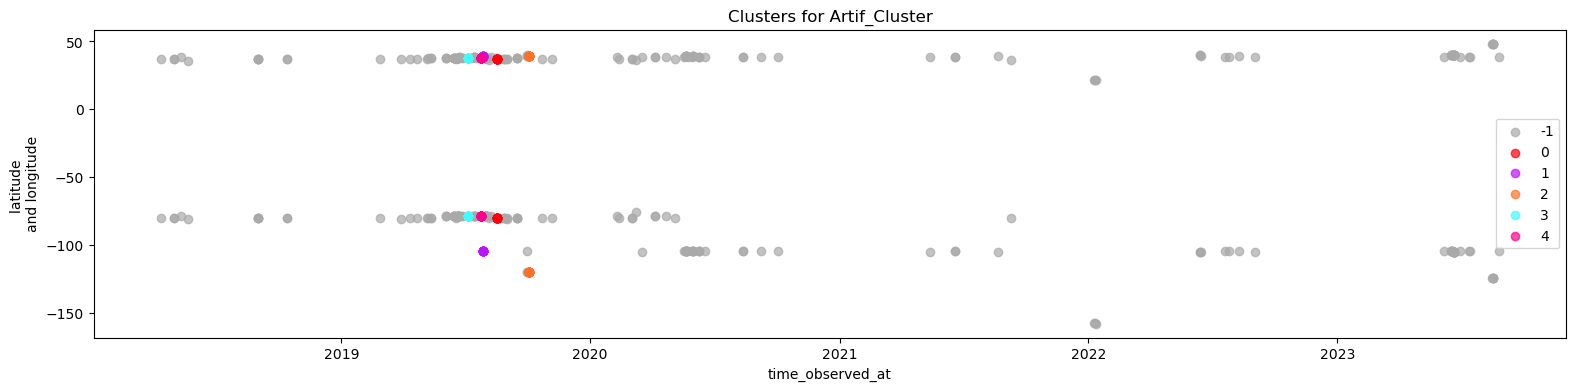

In [29]:
cluster_overview("Artif_Cluster")

Looks like all of the users spurts of several observations in a day happened in 2019. You can see the corresponding lat/lon happening for each cluster.

In [30]:
# attempting a 3D plot to see what it is capable of visualizing
fig = px.scatter_3d(rand_user_df, x='latitude', y='longitude', z='time_observed_at',
              color='Artif_Cluster')
fig.show()

In [31]:
# 3D plot again but without the noise
non_noise_df = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
fig = px.scatter_3d(non_noise_df, x='latitude', y='longitude', z='time_observed_at',
              color='Artif_Cluster')
fig.show()

The 3D plots are generally difficult for me to analyze, read and navigate. I would have an easier time reading 2D graphs that show one view of the "cluster" over space and one view of one of the space columns with respect to time. I'll want to perform this visualization repeatedly so I created a function.

In [32]:
def cluster_views(col, df = rand_user_df, x = "latitude", y = "longitude", z = "obs_time_conv_(minutes)"):
    '''
    Takes in the column name for where the cluster labels are assigned 
    and returns a two graphs for each cluster -- one over space and one with respect to space/time.
    
    Arguments:
    col = Column in dataframe for desired clustering--should be assigned as integers
    df = default is rand_user_df but user can specify a different dataframe
    x = default is the "latitude" columns but user can identify a different independent variable
    y = default is the "longitude" column but user can identify a different dependent variable (for both graphs)
    z = default is the "obs_time_conv_(minutes)" column but user can identify a 2nd independent variable for the 2nd graph
    
    Returns: 
    Scatterplots of x and y beside a scatterplot of z and y for each cluster group specified in "col" 
    (excluding a -1 cluster--this code can be commented out if noise is desired for visualization)
    The scatterplots are scaled so that the x axis, y axis and z axis all span the same relative amount of time/space
    for best comparison of clustering. 
    '''  
    
    # idenifying uniquely named clusters in order
    labels = np.sort(df[col].unique()) 

    
    # find the biggest diff of lat, lon and time for all clusters
    # to make all windows for graphs cover the same approximate area
    lat_diff = 0
    lon_diff = 0
    time_diff = 0
    for i in labels:
        if i <= 0: # excludes noise from visualization
            continue # can comment out this line and the above line if visualizing noise is desired
        cluster = df[df[col] == i]
        x_diff = cluster[x].max() - cluster[x].min() # largest difference in the cluster
        if x_diff > lat_diff:
            lat_diff = x_diff # replaces largest overall diff if cluster diff is bigger
        y_diff = cluster[y].max() - cluster[y].min()
        if y_diff > lon_diff:
            lon_diff = y_diff
        z_diff = cluster[z].max() - cluster[z].min()
        if z_diff > time_diff:
            time_diff = z_diff

    # graph all clusters
    # num of rows:
    r = len(labels) - 1 # if including "noise" will need to remove "-1"

    #set up axes for subplots: 2 per cluster
    plt.subplots(r, 2, figsize=(8, 25))
    # space between subplots (code from geeks for geeks)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.75)

    sub_num = 1 # initial subplot will be 1
    for i in labels:
        if i == -1: # comment out this line and next if noise is desired as a visual
            continue
        # identify the data for the specific cluster
        cluster = df[df[col] == i]
        # create the scale relative to differences calculated above
        min_x = cluster[x].min() - 0.001
        max_x = cluster[x].min() + lat_diff + 0.001
        min_y = cluster[y].min() - 0.001
        max_y = cluster[y].min() + lon_diff + 0.001
        min_z = cluster[z].min() - 10
        max_z = cluster[z].min() + time_diff + 10

        # create scatters for x and y
        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[x], cluster[y], c = '#74ac00')
        plt.title(f'Cluster {i} has {cluster.shape[0]} points')
        plt.xlabel(x)
        plt.xlim(min_x, max_x) 
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1 # move the count along for what subplot we are on
        
        # create scatters for z and y
        plt.subplot(r, 2, sub_num)
        plt.scatter(cluster[z], cluster[y], c = '#337AB7')
        plt.xlabel("time since obs1")
        plt.xlim(min_z, max_z)
        plt.ylim(min_y, max_y)
        plt.ylabel(y)
        sub_num += 1  # move the count along for what subplot we are on

    plt.show()

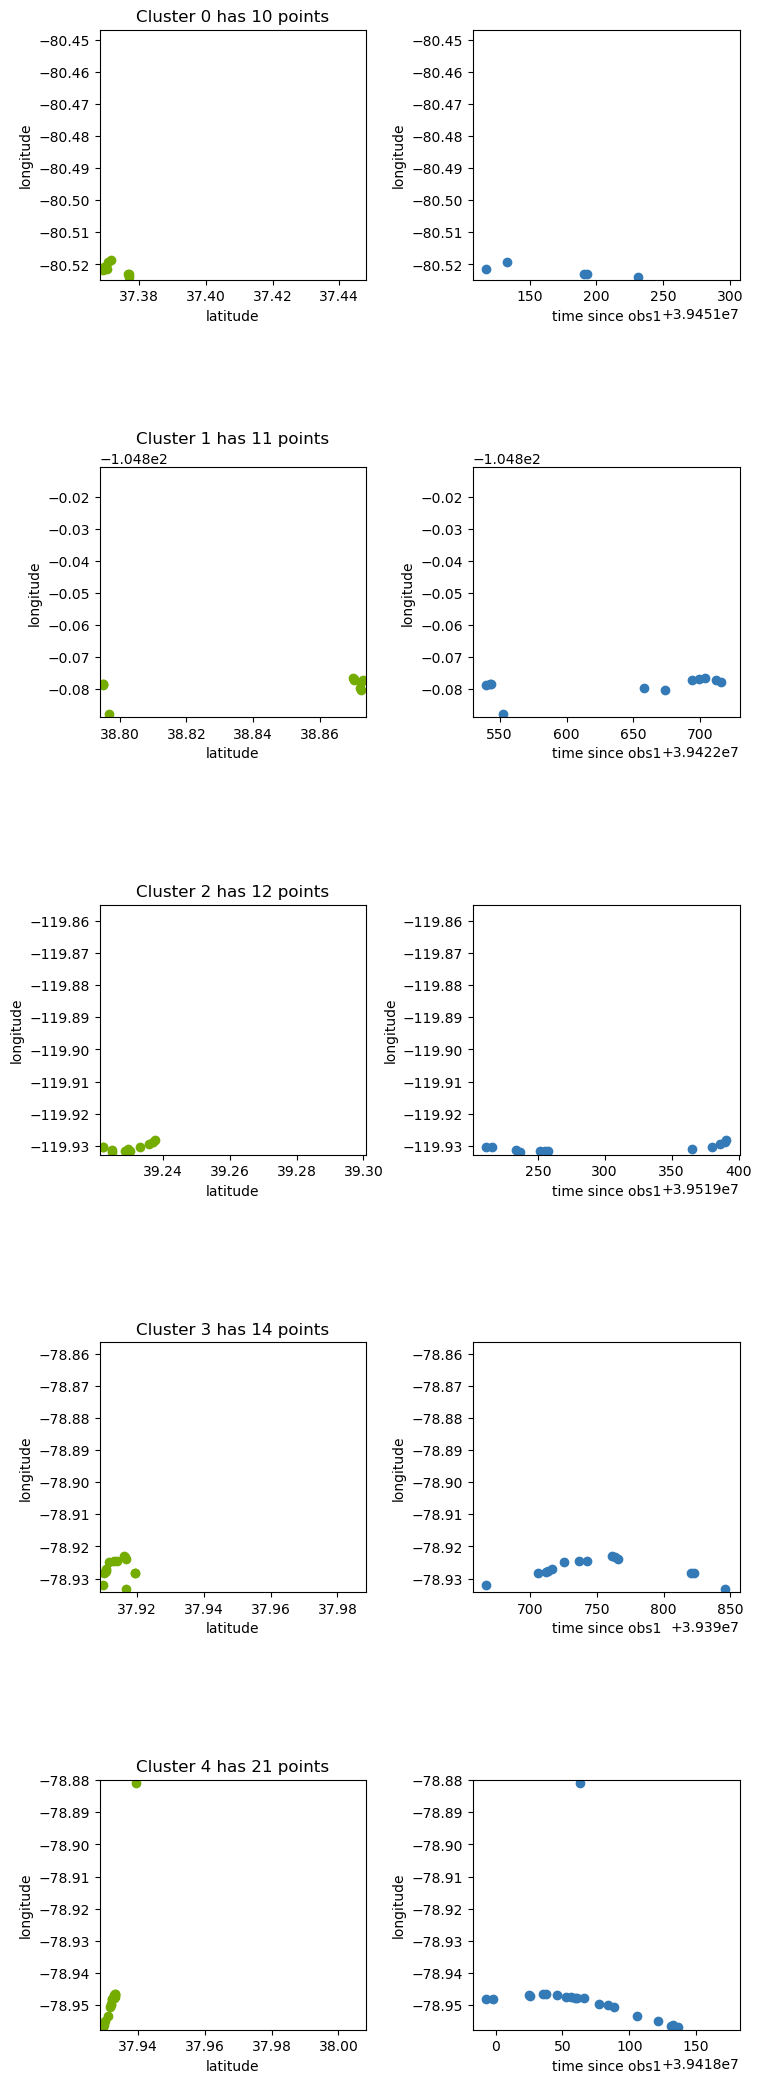

In [33]:
cluster_views("Artif_Cluster")

Some of these look like hikes (cluster 3) while others do not (cluster 1). 

## Exploratory DBSCAN <a id ="7"></a>
Initial look at how DBSCAN performs compared to the baseline analytics model depending on the features chosen for analyzing. No concern for hyperparameters yet. 

### Continuous Time-Related Columns

In [34]:
# continuous columns only

init_db_col = ['id', 'latitude',
       'longitude', 'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'created_at_conv_(minutes)']
init_db_df = rand_user_df[init_db_col]


In [35]:
# use MinMaxScaler to make guessing a good range for eps value easier
# and make distances smaller to compute

mms = MinMaxScaler()
init_db_df_mms = mms.fit_transform(init_db_df)


In [36]:
# choosing eps (max distance between two data points to be considered in same neighborhood) as .1 for now
# choosing min_samples (min number of datapoints it takes to be considered "a cluster") 
# as 10 right now (to match choice in the initial non ML model)
# I keep these parameters through the initial exploration
dbscan_model_01 = DBSCAN(eps=.1, min_samples=10)

# Fit and get labels
cluster_labels_01 = dbscan_model_01.fit_predict(init_db_df_mms)

In [37]:
# how many (non noise) cluseters?
len(np.unique(cluster_labels_01)) - 1

5

In [38]:
# store in a column
rand_user_df["Cluster_Label"] = cluster_labels_01
rand_user_df.sample(3)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\113824663.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id                       observed_on_string observed_on  \
137  33659325  Mon Sep 30 2019 11:02:33 GMT-0700 (PDT)  2019-09-30   
171  46917634  Fri May 22 2020 19:40:23 GMT-0600 (MDT)  2020-05-22   
53   28244988  Fri Jul 05 2019 12:40:33 GMT-0400 (EDT)  2019-07-05   

             time_observed_at                    time_zone  user_id  \
137 2019-09-30 18:02:33+00:00   Pacific Time (US & Canada)   923056   
171 2020-05-23 01:40:23+00:00  Mountain Time (US & Canada)   923056   
53  2019-07-05 16:40:33+00:00   Eastern Time (US & Canada)   923056   

                   created_at quality_grade  \
137 2019-09-30 18:15:25+00:00      needs_id   
171 2020-05-23 01:51:12+00:00        casual   
53  2019-07-05 18:51:53+00:00      needs_id   

                                                   url  \
137  https://www.inaturalist.org/observations/33659325   
171  https://www.inaturalist.org/observations/46917634   
53   https://www.inaturalist.org/observations/28244988   

                                             image_url  ... obs_year  \
137  https://static.inaturalist.org/photos/52888790...  ...     2019   
171  https://static.inaturalist.org/photos/74408126...  ...     2020   
53   https://static.inaturalist.org/photos/44016203...  ...     2019   

     obs_month  obs_day  obs_hour  created_year  created_month  created_day  \
137          9       30        18          2019              9           30   
171          5       23         1          2020              5           23   
53           7        5        16          2019              7            5   

     created_hour  Artif_Cluster Cluster_Label  
137            18             -1            -1  
171             1             -1             3  
53             18              3             0  

[3 rows x 41 columns]

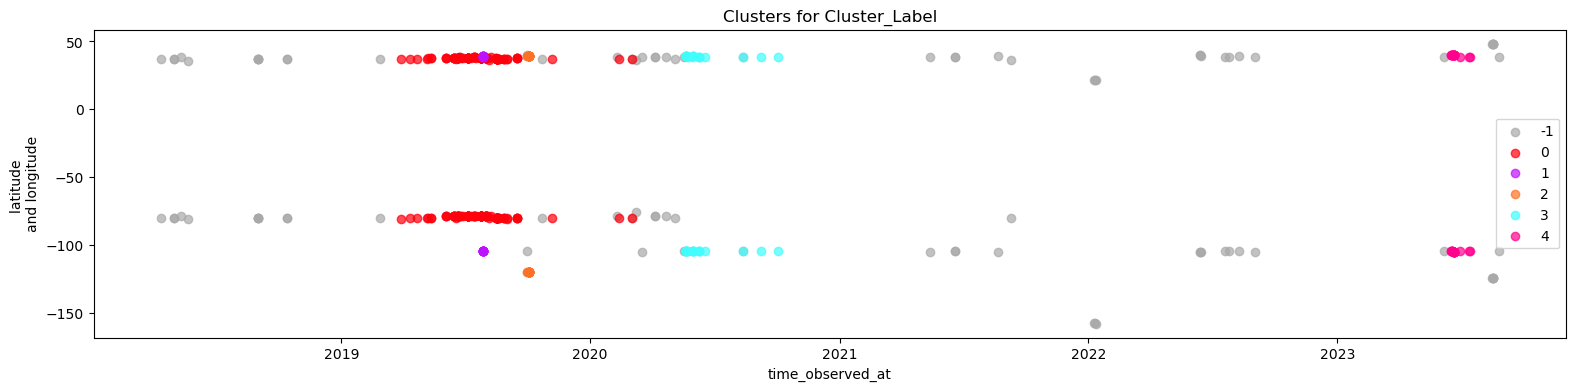

In [39]:
# visualize
cluster_overview("Cluster_Label")

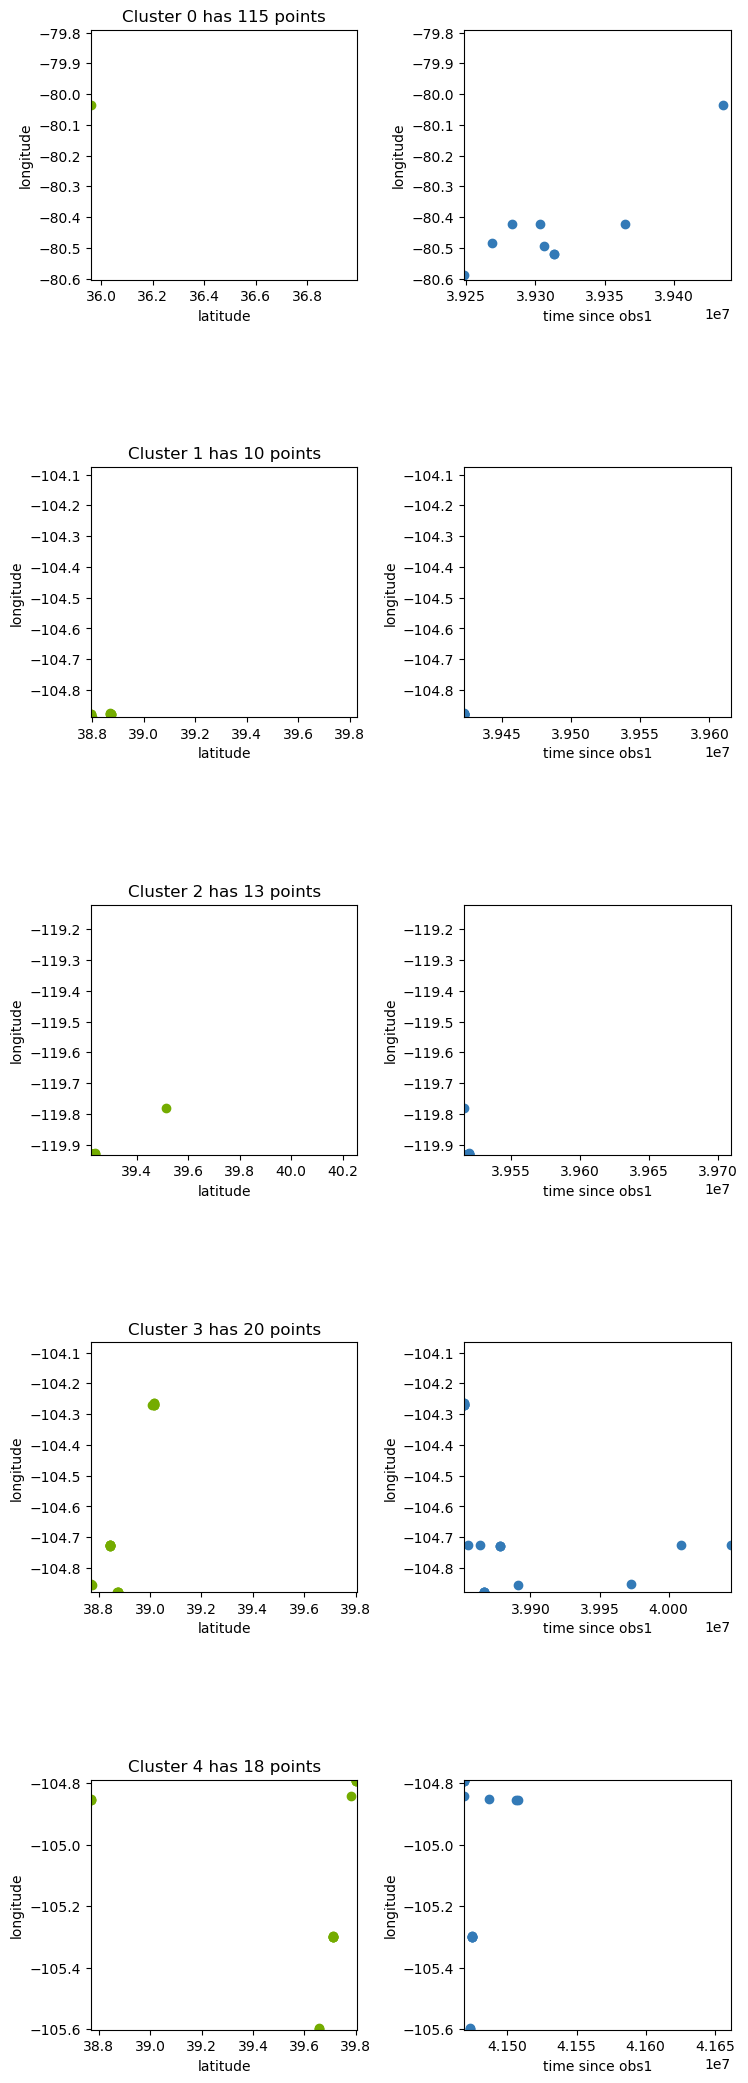

In [40]:
cluster_views("Cluster_Label")

In [41]:
# silhouette score of baseline non-ML model using the same columns as db_01 used

non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]

artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()
init_db_df_array = non_noise[init_db_col].to_numpy()

silhouette_score(init_db_df_array, artificial_cluster_array)

0.9886512196271166

In [42]:
# silhouette score of dbscan_model_01 (using unscaled data to compare to above)

cluster_labels = dbscan_model_01.fit_predict(init_db_df_mms)
    
silhouette_score(init_db_df[cluster_labels != -1], cluster_labels[cluster_labels != -1])


0.048969655362951524

I'm sure the DBSCAN with only continuous columns is seeing something that warrants clustering, but it isn't what I'm looking for. The silhouette score is poor compared to my non ML clustering even though the score is relative to the DBSCAN's feature columns

### Discrete Time Columns

In [43]:
# discrete columns only
db_df_2 = rand_user_df[['latitude', 'longitude', 'obs_month', 'obs_day', 'obs_hour', 'obs_year',
       'created_year', 'created_month', 'created_day', 'created_hour']]

In [44]:
mms = MinMaxScaler()
db_df_2_mms = mms.fit_transform(db_df_2)

dbscan_model_02 = DBSCAN(eps=.1, min_samples=10)

# Fit and get labels
cluster_labels_02 = dbscan_model_02.fit_predict(db_df_2_mms)

In [45]:
len(np.unique(cluster_labels_02)) - 1

2

In [46]:
rand_user_df["Cluster_Label"] = cluster_labels_02


C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\2790669217.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



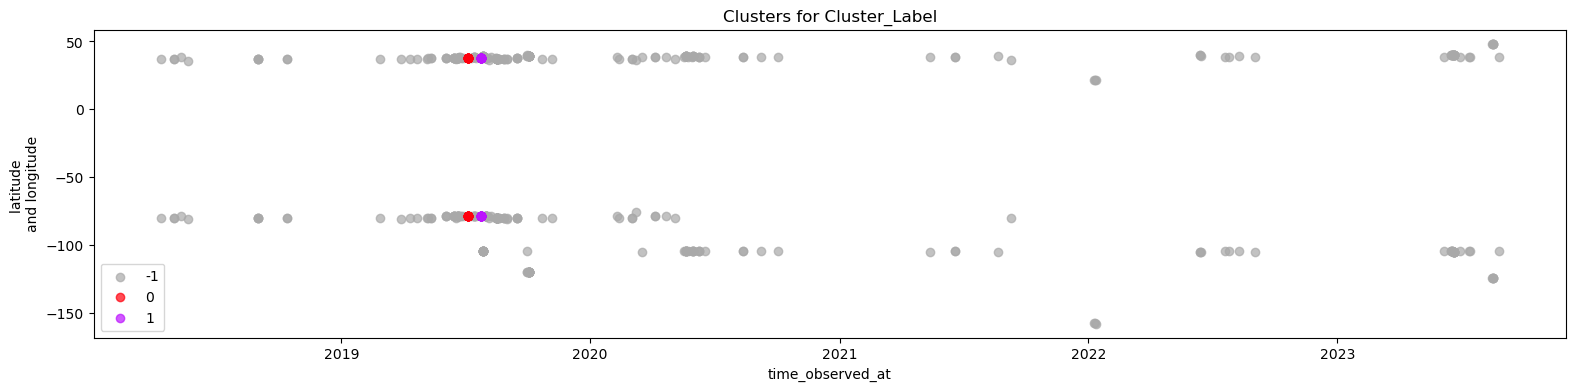

In [47]:
cluster_overview("Cluster_Label")

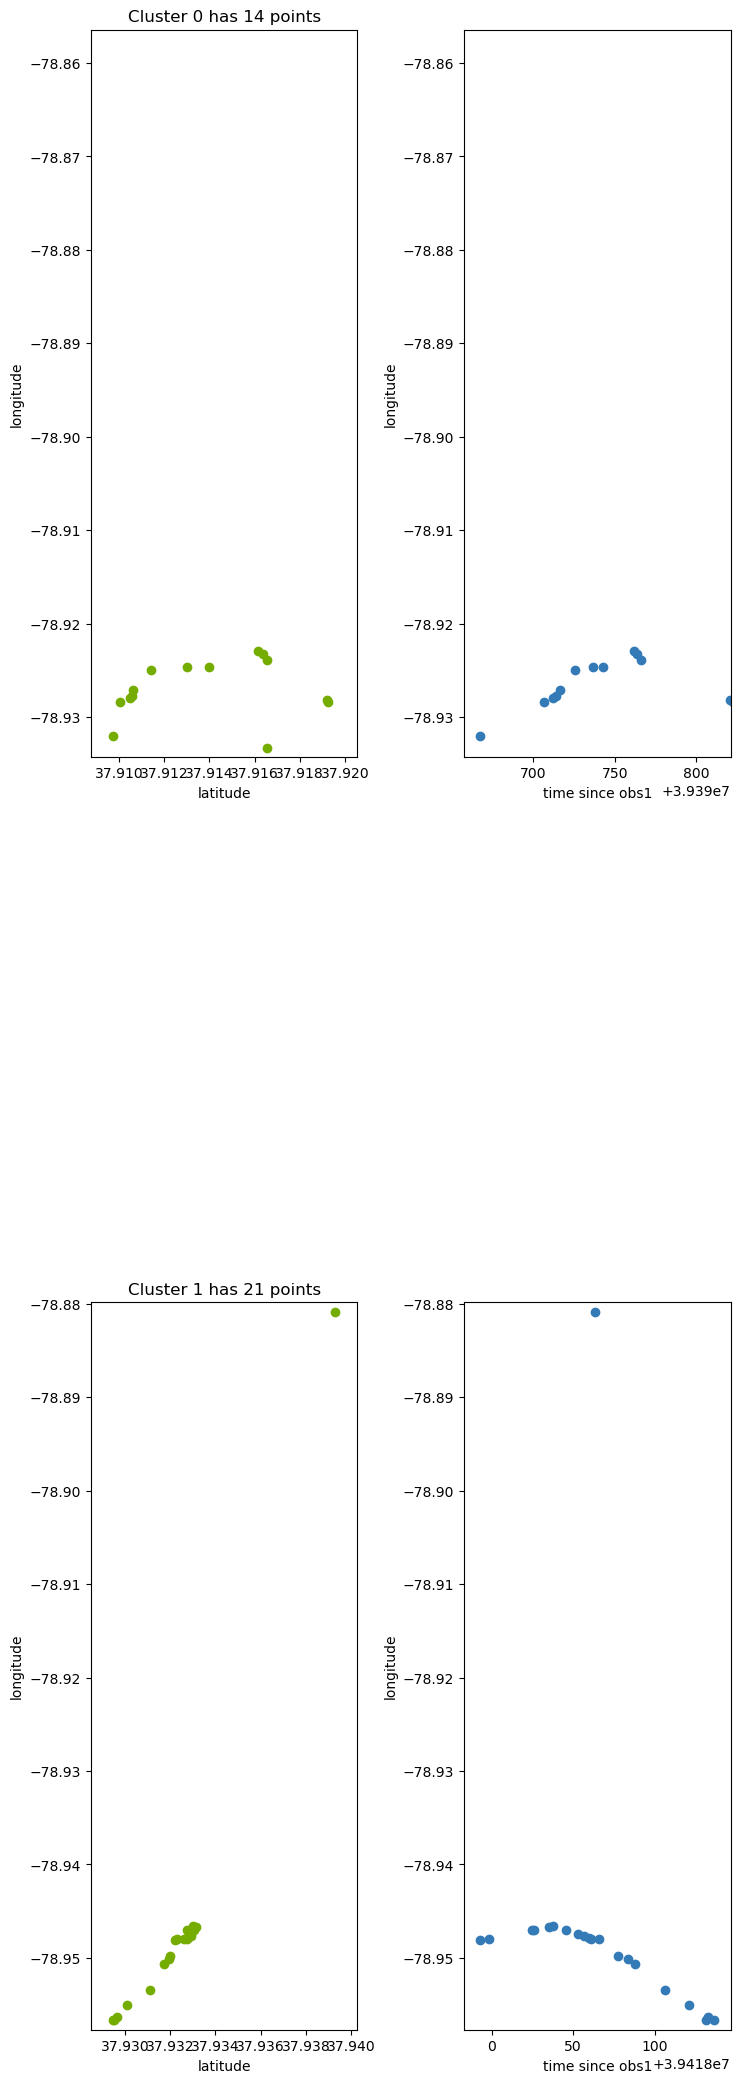

In [48]:
cluster_views("Cluster_Label")

In [49]:
# silhouette score of baseline non-ML model using the same columns as db_02 used
# next two lines defined in previous block but commented out here in case

#non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
#artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()

db_df_2_array = non_noise[db_df_2.columns].to_numpy()

silhouette_score(db_df_2_array, artificial_cluster_array)

0.8599262461123098

In [50]:
# silhouette score of dbscan_model_02 on unscaled data for comparison
    
silhouette_score(db_df_2[cluster_labels_02 != -1], cluster_labels_02[cluster_labels_02 != -1])

0.9676620461307004

OK Discrete columns seem to do well here--it only found 2 clusters but likely pretty solid hikes but it seemed to specifically choose the 2 clusters I found with non ML clustering that, out of those 5, were mostly likely hikes. So it's focused in the right place and more discriminating. It's silhouette score outperforms the non ML clustering.

### Combo Time Columns


In [51]:
# chose four features from each--continuous and discrete
db_df_3 = rand_user_df[['id', 'latitude',
       'longitude', 'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'obs_year',
       'obs_month', 'obs_day', 'obs_hour']]

In [52]:
mms = MinMaxScaler()
db_df_3_mms = mms.fit_transform(db_df_3)

dbscan_model_03 = DBSCAN(eps=.1, min_samples=10)

# Fit and get labels
cluster_labels_03 = dbscan_model_03.fit_predict(db_df_3_mms)

In [53]:
len(np.unique(cluster_labels_03)) - 1

5

In [54]:
rand_user_df["Cluster_Label"] = cluster_labels_03

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\1988594208.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



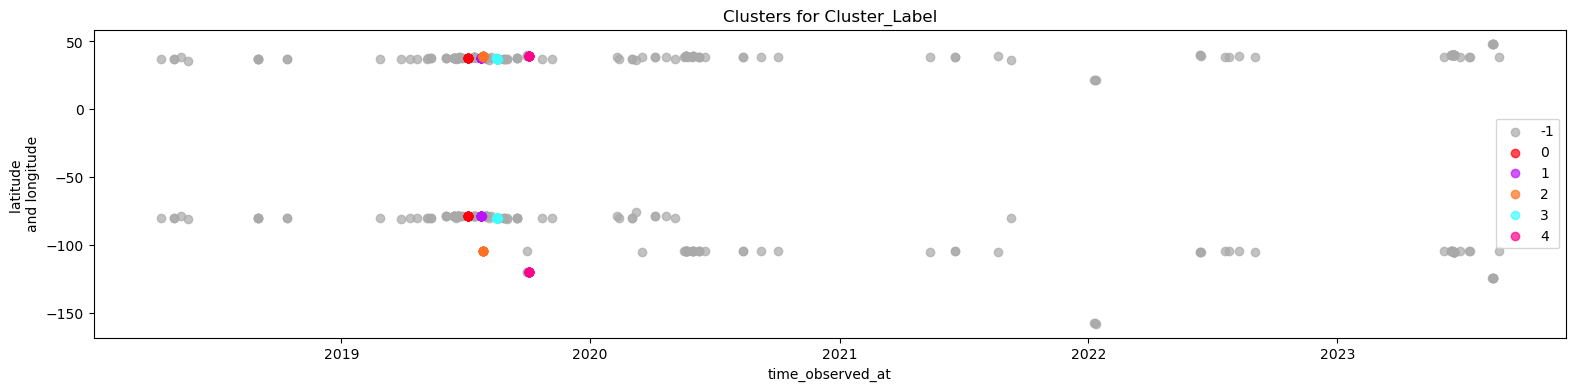

In [55]:
cluster_overview("Cluster_Label")

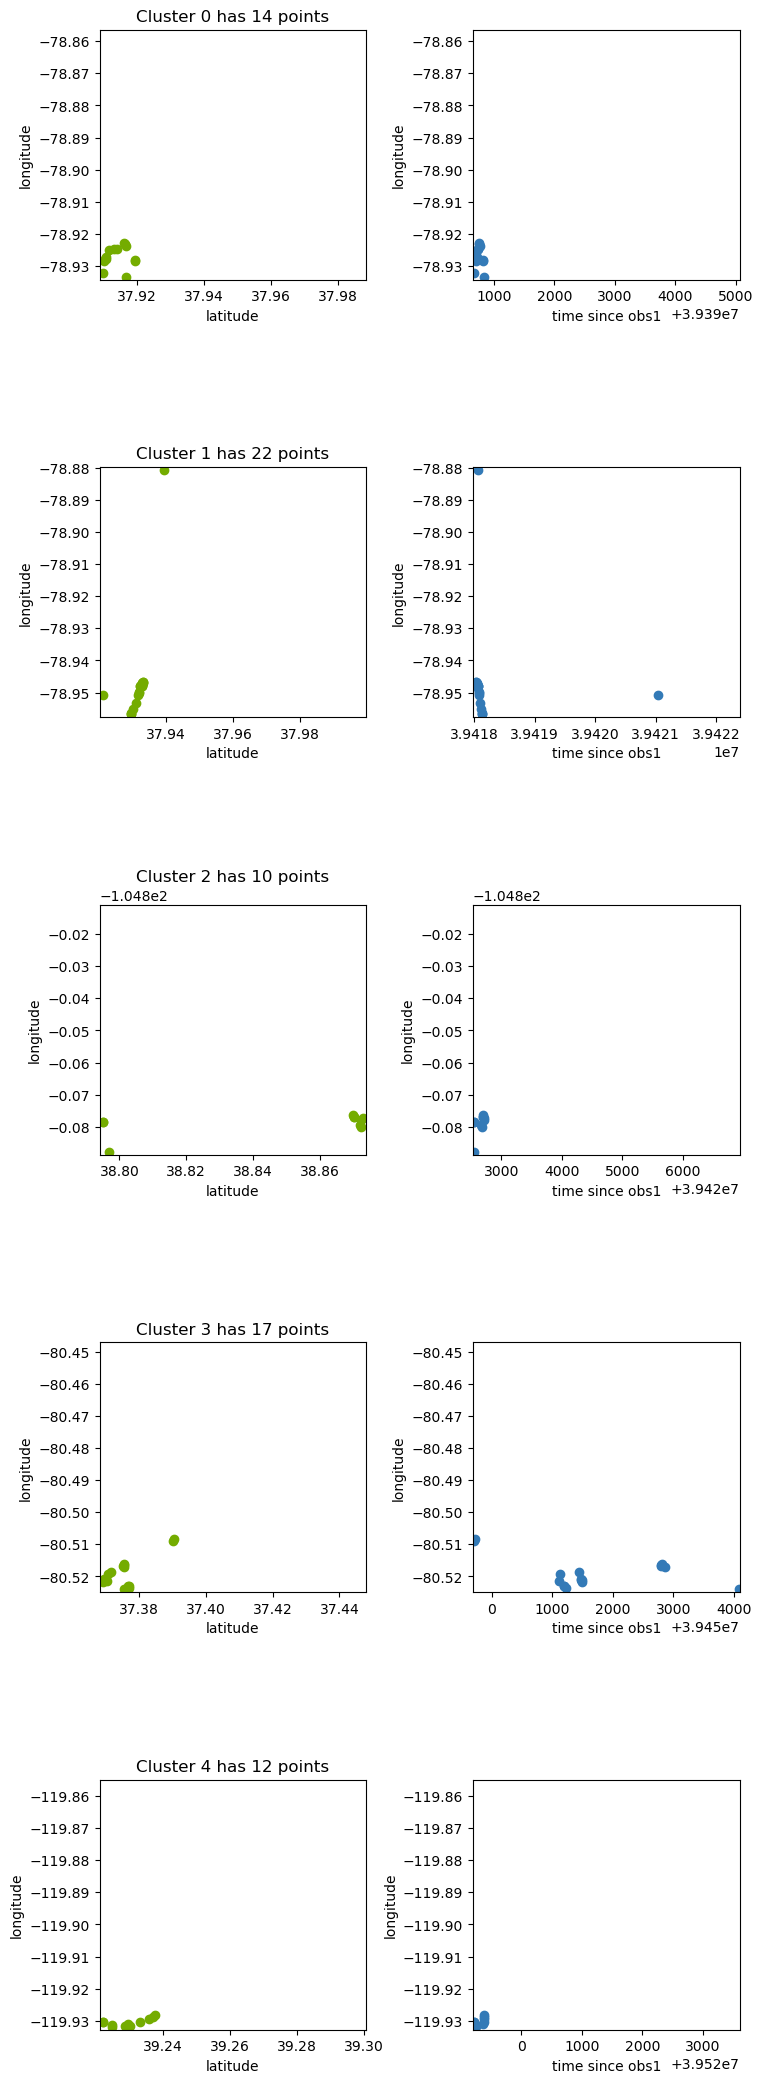

In [56]:
cluster_views("Cluster_Label")

In [57]:
# silhouette score of baseline non-ML model using the same columns as db_03 used
# next two lines defined in previous block but commented out here in case

#non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
#artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()

db_df_3_array = non_noise[db_df_3.columns].to_numpy()

silhouette_score(db_df_3_array, artificial_cluster_array)

0.9886498749588256

In [58]:
# silhouette score of dbscan_model_03 on unscaled data for comparison
    
silhouette_score(db_df_3[cluster_labels_03 != -1], cluster_labels_03[cluster_labels_03 != -1])

0.9511129466433257

This found 5 clusters, all with reasonable evidence for being a hike and performed close to but not quite as well as the non ML clustering. So it's a little more generous than the discrete only.

## Optimizing DBSCAN<a id = "8"></a>

### Feature Selection
Testing different sets of time- and distance- related features against each other. 

I'm creating a function df_feat_sel() for choosing a slice of the user-specific dataframe based on feature selections. This way I can put the function in an optimization loop. And before that, I'm defining the dictionary that df_feat_sel() will call on to make those slices but putting it in its own function which allows a user to also call on the feat_sel_param function to see what the feature codes mean.

In [120]:
# Part of a help function for df_feat_sel

def feat_sel_param(i):
    '''
    Takes an integer and returns the feature selection information.
    Meant to be used as part of 'help' for using the feat_sel function
    as a way of knowing what features each integer is associated with.
    
    Arguments:
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    Returns:
    Tuple with first element a string that acts as a descriptive title of the selected features
    and second element a list of the column headings for features chosen for that description
    
    '''
    # Creating the dictionary for feature selection
    # these can be edited here (added to, deleted or revised...) and rerun to see results for different feature selection
    feature_sel_options = {}

    feature_sel_options[0] = ("continuous_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)'])

    feature_sel_options[1] = ("continuous_light",
                              ['latitude','longitude', 
                               'km_diff','obs_time_conv_(minutes)'])

    feature_sel_options[2] = ("discrete_heavy",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year',
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[3] = ("discrete_light",
                              ['latitude', 'longitude', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year'])

    # including this one to imitate the features I used for my own baseline model
    feature_sel_options[4] = ("discrete_barebones",
                              ['obs_month', 'obs_day', 'obs_year'])

    feature_sel_options[5] = ("combo_heavy", 
                              ['id', 'latitude', 'longitude', 
                               'minute_diff', 'km_diff', 
                               'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year', 
                               'created_year', 'created_month', 'created_day', 'created_hour'])

    feature_sel_options[6] = ("combo_light", 
                              ['latitude', 'longitude', 
                               'minute_diff', 'km_diff',  
                               'obs_month', 'obs_day', 'obs_year'])
    
    feature_sel_options[7] = ("combo_discrete_heavy",
                              ['latitude', 'longitude', 'minute_diff',
                               'obs_month', 'obs_day', 'obs_hour', 'obs_year',
                               'created_year', 'created_month', 'created_day', 'created_hour'])
    
    
    # returns feature selection values if i is appropriate/exists as key
    # (also allowing user to also save and access the column lists without the df_feat_sel feature)
    if i in range(len(feature_sel_options)):
        return feature_sel_options[i]
    # but prints helpful info if i is not a dictionary key
    else:
        print(f'Input needs to be an integer between 0 and {len(feature_sel_options) - 1}')

num_feat_sel = 8 # CHANGE THIS IF YOU CHANGE NUMBER OF ITEMS IN DICTIONARY

In [94]:
def df_feat_sel(df, i):
    
    '''
    Takes a user-specific dataframe (df) and an integer mapped to a specific set of features
    and returns a dataframe for cluster analysis. 
    
    Arguments:
    df -- name of user-specific dataframe from the df_sp dataframe (after discrete time columns have been added)
    I'm choosing to leave this as needing specification anticipating that in the future I will change dataframe names
    as I change the user under consideration
    i -- integer 0 to 6 acting as keys in the dictionary for the feature selections
    
    For a reminder of what i maps to, use feat_sel_param() function
    
    Returns:
    Dataframe slice of original dataframe with only the columns chosen for feature selection
    
    '''
    
    # calls on the dictionary function and chooses the 2nd entry of the tuple for the column heading and then take the slice
    sel_df = df[feat_sel_param(i)[1]]
   

    return sel_df

### Feature and Hyperparameter Optimization

Below runs code to 
a) try out the various feature selection options
b) try out various hyperparameters for DBSCAN (eps and min_samples)
c) create a dataframe for each run with relevant data for comparison

In particular, the calculation of silhouette scores is tricky, because there is a question of "what features should the score be relative to?" for cross comparison, especially when comparing to the non ML model. In all cases, the sil scores were calculated with unscaled data.
I've chosen a couple of options and put them into the dataframe:
1) An "absolute" silhouette score where all models have a sil score calculated relative to all the numerical columns in the dataframe
2) A 'relative" silhouette score where each model is given a sil score calculated relative to its own feature columns
3) For the non ML model--a sil score calculated relative to each DBSCAN model's feature columns for direct comparison between the two

Both ways of looking at it proved to be helpful. 

In [121]:
# choosing all columns with non boolean numeric columns 
# to create a dataframe on which to compare "absolute" silhouette scores
# from one cluster to the other

absolute_columns = ['id', 'num_identification_agreements',
       'num_identification_disagreements', 'latitude',
       'longitude', 'positional_accuracy', 'public_positional_accuracy',
       'minute_diff', 'km_diff',
       'obs_time_conv_(minutes)', 'created_at_conv_(minutes)', 'obs_year',
       'obs_month', 'obs_day', 'obs_hour', 'created_year', 'created_month',
       'created_day', 'created_hour'] 

absolute_df_for_scoring = rand_user_df[absolute_columns]
    
#empty dataframe for analysis of silhouette scores
sil_scores = pd.DataFrame()
index = 0 # indexing unit for dataframe

# i loops through the different feature selections
for i in range(num_feat_sel): 
    # create slice of dataframe for modeling with feature_code
    subset = df_feat_sel(rand_user_df, i)
    
    # scale data --choosing MinMaxScaler to make it easier to guess at good values for DBSCAN eps
    mms = MinMaxScaler()
    subset_scaled = mms.fit_transform(subset)
    
    # looping through choices for eps and min_samples for DBSCAN
    for e in [.001, .005, .01, .05, .1, .25, .5, .75]:
        for m in [10, 9, 8, 7, 6, 5]: # going down so that Artif_Cluster will end on most clusters found for final visualization comparisons
            
            # creating baseline set given min_sample of m
            top_dates = potential_hikes[potential_hikes.values >= m].index
            
            artificial_cluster = {}
            n = 0
            for day in top_dates:
                artificial_cluster[day] = n
                n += 1
            artificial_cluster
            
            # repopulating "Artif_Cluster" column depending on the m for min_samples so sil scores can be properly compared
            for ind in range(rand_user_df.shape[0]):
                # if observated date is in the top_dates, array, the new column will be filled with the corresponding cluster number
                if rand_user_df.loc[ind, "time_observed_at"].strftime('%D') in top_dates:
                    rand_user_df.loc[ind, "Artif_Cluster"] = artificial_cluster[rand_user_df.loc[ind, "time_observed_at"].strftime('%D')]
                # otherwise, the new column will be assigned a -1 (the way DBSCAN does for non clusters)
                else:
                    rand_user_df.loc[ind, "Artif_Cluster"] = -1
            rand_user_df["Artif_Cluster"] = rand_user_df["Artif_Cluster"].astype(int)
            
            # for silhouette score of artificial cluster, relative to chosen subset and min_samples
            non_noise = rand_user_df[rand_user_df["Artif_Cluster"] != -1]
            artificial_cluster_array = non_noise["Artif_Cluster"].to_numpy()
            baseline_relative = non_noise[subset.columns].to_numpy()
            baseline_rel_sil = silhouette_score(baseline_relative, artificial_cluster_array)
            
            # I'm thinking now that it would have made sense to put the m on the outside loop 
            # so this only needed to be done fewer times? since the Artif_Cluster doesn't depend on the e loop
            # Was just going by the order of "most important feature" and didn't consider the computing
            # WORTH REPROGRAMMING IN NEXT NOTEBOOK WHEN MORE USERS WILL BE RUN
            
            #instantiate model
            dbscan_model = DBSCAN(eps=e, min_samples=m)
            # Fit and get labels
            cluster_labels = dbscan_model.fit_predict(subset_scaled)
            num_clusters = len(np.unique(cluster_labels)) - 1 # subtract one for noise
            
            
            # silhouette scores for db
            if num_clusters > 1: # silhouette scores require at least two groups to analyze 
                # silhouette score relative to the subset columns
                db_rel_sil = silhouette_score(subset[cluster_labels != -1], cluster_labels[cluster_labels != -1])
                # silhouette score relative to the "absolute" dataset created at top of cell
                db_abs_sil = silhouette_score(absolute_df_for_scoring[cluster_labels != -1], cluster_labels[cluster_labels != -1])
            else: 
                db_rel_sil = np.NaN
                db_abs_sil = np.NaN

                
            
            # store info in analysis dataframe
            sil_scores.loc[index, "feature_code"] = i
            sil_scores.loc[index, "eps"] = e
            sil_scores.loc[index, "min_samples"] = m
            sil_scores.loc[index, "baseline_rel_silhouette"] = baseline_rel_sil
            sil_scores.loc[index, "db_rel_silhouette"] = db_rel_sil
            sil_scores.loc[index, "db_abs_silhouette"] = db_abs_sil
            sil_scores.loc[index, "num_db_clusters"] = num_clusters
            sil_scores.loc[index, "num_bl_clusters"] = len(np.unique(artificial_cluster_array))
            index += 1

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\4142853994.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [122]:
baseline_absolute = non_noise[absolute_df_for_scoring.columns].to_numpy()
baseline_abs_sil = silhouette_score(baseline_absolute, artificial_cluster_array)
print(f'Overall baseline absolute silhouette score is {baseline_abs_sil}. \n For relative scores look at sil_scores dataframe.')

Overall baseline absolute silhouette score is 0.9760600129707622. 
 For relative scores look at sil_scores dataframe.


In [123]:
# Overview of set for not null scores
sil_scores[sil_scores["db_rel_silhouette"].notnull()].describe()

feature_code         eps  min_samples  baseline_rel_silhouette  \
count    260.000000  260.000000   260.000000               260.000000   
mean       3.415385    0.114338     7.300000                 0.586713   
std        2.330873    0.146781     1.722663                 0.611553   
min        0.000000    0.001000     5.000000                -0.508274   
25%        1.000000    0.005000     6.000000                -0.406539   
50%        3.000000    0.050000     7.000000                 0.976286   
75%        6.000000    0.137500     9.000000                 0.988651   
max        7.000000    0.500000    10.000000                 1.000000   

       db_rel_silhouette  db_abs_silhouette  num_db_clusters  num_bl_clusters  
count         260.000000         260.000000       260.000000       260.000000  
mean            0.429147           0.639838         6.026923         7.815385  
std             0.552846           0.423650         2.783578         2.585330  
min            -0.687214          -0.582005         2.000000         5.000000  
25%             0.101195           0.342433         4.000000         6.000000  
50%             0.528551           0.899280         6.000000         6.000000  
75%             0.977651           0.989630         8.000000        11.000000  
max             1.000000           0.999706        14.000000        11.000000

Describe table shows there are times dbscan outperforms my baseline model

In [124]:
# What do the top absolute scores look like?
top_abs_db_scores = sil_scores[(sil_scores["db_rel_silhouette"].notnull())].sort_values(by = "db_abs_silhouette").tail(20)
top_abs_db_scores

feature_code    eps  min_samples  baseline_rel_silhouette  \
114           2.0  0.050         10.0                 0.859926   
162           3.0  0.050         10.0                 0.889824   
354           7.0  0.050         10.0                -0.417252   
258           5.0  0.050         10.0                 0.988651   
360           7.0  0.100         10.0                -0.417252   
120           2.0  0.100         10.0                 0.859926   
264           5.0  0.100         10.0                 0.988651   
288           6.0  0.001         10.0                -0.412696   
347           7.0  0.005          5.0                -0.473197   
257           5.0  0.010          5.0                 0.976286   
353           7.0  0.010          5.0                -0.473197   
251           5.0  0.005          5.0                 0.976286   
346           7.0  0.005          6.0                -0.473197   
256           5.0  0.010          6.0                 0.976286   
352           7.0  0.010          6.0                -0.473197   
340           7.0  0.001          6.0                -0.473197   
244           5.0  0.001          6.0                 0.976286   
250           5.0  0.005          6.0                 0.976286   
341           7.0  0.001          5.0                -0.473197   
245           5.0  0.001          5.0                 0.976286   

     db_rel_silhouette  db_abs_silhouette  num_db_clusters  num_bl_clusters  
114           0.970694           0.998645              2.0              5.0  
162           0.962866           0.998645              2.0              5.0  
354           0.038450           0.998645              2.0              5.0  
258           0.998768           0.998645              2.0              5.0  
360           0.018690           0.998671              2.0              5.0  
120           0.967662           0.998671              2.0              5.0  
264           0.998791           0.998671              2.0              5.0  
288           0.563919           0.999196              3.0              5.0  
347           0.129041           0.999277              8.0             11.0  
257           0.999504           0.999277              8.0             11.0  
353           0.129041           0.999277              8.0             11.0  
251           0.999687           0.999456              8.0             11.0  
346           0.358553           0.999494              3.0             11.0  
256           0.999680           0.999494              3.0             11.0  
352           0.358553           0.999494              3.0             11.0  
340           0.746628           0.999598              2.0             11.0  
244           0.999845           0.999598              2.0             11.0  
250           0.999845           0.999598              2.0             11.0  
341           0.479696           0.999706              6.0             11.0  
245           0.999823           0.999706              6.0             11.0

In [125]:
top_abs_db_scores["feature_code"].value_counts()

7.0    8
5.0    8
2.0    2
3.0    1
6.0    1
Name: feature_code, dtype: int64

In [126]:
# What do the top relative DBSCAN scores look like?
top_rel_db_scores = sil_scores[(sil_scores["db_rel_silhouette"].notnull())].sort_values(by = "db_rel_silhouette").tail(20)
top_rel_db_scores

feature_code    eps  min_samples  baseline_rel_silhouette  \
250           5.0  0.005          6.0                 0.976286   
244           5.0  0.001          6.0                 0.976286   
192           4.0  0.001         10.0                 1.000000   
193           4.0  0.001          9.0                 1.000000   
194           4.0  0.001          8.0                 1.000000   
195           4.0  0.001          7.0                 1.000000   
196           4.0  0.001          6.0                 1.000000   
198           4.0  0.005         10.0                 1.000000   
199           4.0  0.005          9.0                 1.000000   
200           4.0  0.005          8.0                 1.000000   
201           4.0  0.005          7.0                 1.000000   
202           4.0  0.005          6.0                 1.000000   
203           4.0  0.005          5.0                 1.000000   
204           4.0  0.010         10.0                 1.000000   
206           4.0  0.010          8.0                 1.000000   
207           4.0  0.010          7.0                 1.000000   
208           4.0  0.010          6.0                 1.000000   
209           4.0  0.010          5.0                 1.000000   
197           4.0  0.001          5.0                 1.000000   
205           4.0  0.010          9.0                 1.000000   

     db_rel_silhouette  db_abs_silhouette  num_db_clusters  num_bl_clusters  
250           0.999845           0.999598              2.0             11.0  
244           0.999845           0.999598              2.0             11.0  
192           1.000000           0.988297              5.0              5.0  
193           1.000000           0.989223              6.0              6.0  
194           1.000000           0.989223              6.0              6.0  
195           1.000000           0.989223              6.0              6.0  
196           1.000000           0.976060             11.0             11.0  
198           1.000000           0.988297              5.0              5.0  
199           1.000000           0.989223              6.0              6.0  
200           1.000000           0.989223              6.0              6.0  
201           1.000000           0.989223              6.0              6.0  
202           1.000000           0.976060             11.0             11.0  
203           1.000000           0.976060             11.0             11.0  
204           1.000000           0.988297              5.0              5.0  
206           1.000000           0.989223              6.0              6.0  
207           1.000000           0.989223              6.0              6.0  
208           1.000000           0.976060             11.0             11.0  
209           1.000000           0.976060             11.0             11.0  
197           1.000000           0.976060             11.0             11.0  
205           1.000000           0.989223              6.0              6.0

In [127]:
top_rel_db_scores["feature_code"].value_counts()

4.0    18
5.0     2
Name: feature_code, dtype: int64

Choosing the "barebones discrete" (#4) imitates my own non ML model almost exactly. So while the top scores relative to its own feature column selection is at 1, its absolute score doesn't do as well as other feature selections nor does it outperform my model when keeping things relative to its feature columns. So it seems we'll get more information about "better" models by looking at the absolute score and the relative scores that outperform mine

In [128]:
# What are the top relative DBSCAN scores that outperform the non ML model?
comparative_top = sil_scores[sil_scores["db_rel_silhouette"] > sil_scores["baseline_rel_silhouette"]].sort_values(by = "db_rel_silhouette").tail(20)
comparative_top

feature_code    eps  min_samples  baseline_rel_silhouette  \
160           3.0  0.010          6.0                 0.833265   
149           3.0  0.001          5.0                 0.833265   
161           3.0  0.010          5.0                 0.833265   
155           3.0  0.005          5.0                 0.833265   
259           5.0  0.050          9.0                 0.989536   
260           5.0  0.050          8.0                 0.989536   
258           5.0  0.050         10.0                 0.988651   
264           5.0  0.100         10.0                 0.988651   
113           2.0  0.010          5.0                 0.762117   
107           2.0  0.005          5.0                 0.762117   
101           2.0  0.001          5.0                 0.762117   
112           2.0  0.010          6.0                 0.762117   
106           2.0  0.005          6.0                 0.762117   
100           2.0  0.001          6.0                 0.762117   
257           5.0  0.010          5.0                 0.976286   
256           5.0  0.010          6.0                 0.976286   
251           5.0  0.005          5.0                 0.976286   
245           5.0  0.001          5.0                 0.976286   
250           5.0  0.005          6.0                 0.976286   
244           5.0  0.001          6.0                 0.976286   

     db_rel_silhouette  db_abs_silhouette  num_db_clusters  num_bl_clusters  
160           0.996393           0.693992              7.0             11.0  
149           0.996815           0.624679             10.0             11.0  
161           0.996815           0.624679             10.0             11.0  
155           0.996815           0.624679             10.0             11.0  
259           0.998085           0.997847              3.0              6.0  
260           0.998085           0.997847              3.0              6.0  
258           0.998768           0.998645              2.0              5.0  
264           0.998791           0.998671              2.0              5.0  
113           0.999114           0.836779              9.0             11.0  
107           0.999114           0.836779              9.0             11.0  
101           0.999114           0.836779              9.0             11.0  
112           0.999421           0.997097              5.0             11.0  
106           0.999421           0.997097              5.0             11.0  
100           0.999421           0.997097              5.0             11.0  
257           0.999504           0.999277              8.0             11.0  
256           0.999680           0.999494              3.0             11.0  
251           0.999687           0.999456              8.0             11.0  
245           0.999823           0.999706              6.0             11.0  
250           0.999845           0.999598              2.0             11.0  
244           0.999845           0.999598              2.0             11.0

In [129]:
comparative_top["feature_code"].value_counts()

5.0    10
2.0     6
3.0     4
Name: feature_code, dtype: int64

In general feature selection 5 (combo of continuous and discrete with all possible values that fit that description) shows itself in the top performing in all cases excluding the "relative DB score" as single measure. Small eps and small cluster sizes seem to also be best.

## Visualizing Top Model(s)<a id ="9"></a>

In [152]:
pd.set_option('display.max_rows', None) # to show entire comparison dataframe
def choose_a_model(i, e, m, df = rand_user_df):
    '''
    Takes in hyperparameters for the DBSCAN, creates the model, stores the clusters in rand_user_df
    then prints out visuals and dataframes for analysis
    
    Arguments: 
    i: int, number of dictionary key for the feature selection set of columns
    e: float, eps for dbscan (max dist between two samples to be considered inside of same cluster)
    m: int, min_sample for dbscan (min number of datapoints required to be considered a cluster)
    optional: df--dataframe for consideration, default is rand_user_df
    
    Actions:
    Stores cluster labels in rand_user_df
    Visuals for cluster_overview and cluster_views for new cluster labels
    
    Returns:
    A dataframe that shows (max) baseline clusters against dbscan clusters
    
    '''
    
    subset = df_feat_sel(rand_user_df, i)

    # scale data --choosing MinMaxScaler to make it easier to guess at good values for DBSCAN eps
    mms = MinMaxScaler()
    subset_scaled = mms.fit_transform(subset)

    #instantiate model
    dbscan_model = DBSCAN(eps=e, min_samples=m)
    # Fit and get labels
    cluster_labels = dbscan_model.fit_predict(subset_scaled)
    num_clusters = len(np.unique(cluster_labels)) - 1 # subtract one for noise
    rand_user_df["Cluster_Label"] = cluster_labels
    
    cluster_overview("Cluster_Label")
    cluster_views("Cluster_Label")
    
    # How do the found clusters for non ML and DBSCAN compare?
    cluster_comp = rand_user_df[(rand_user_df["Cluster_Label"] != -1) | (rand_user_df["Artif_Cluster"] != -1)][["Artif_Cluster", "Cluster_Label"]]
    return cluster_comp

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\1880991399.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



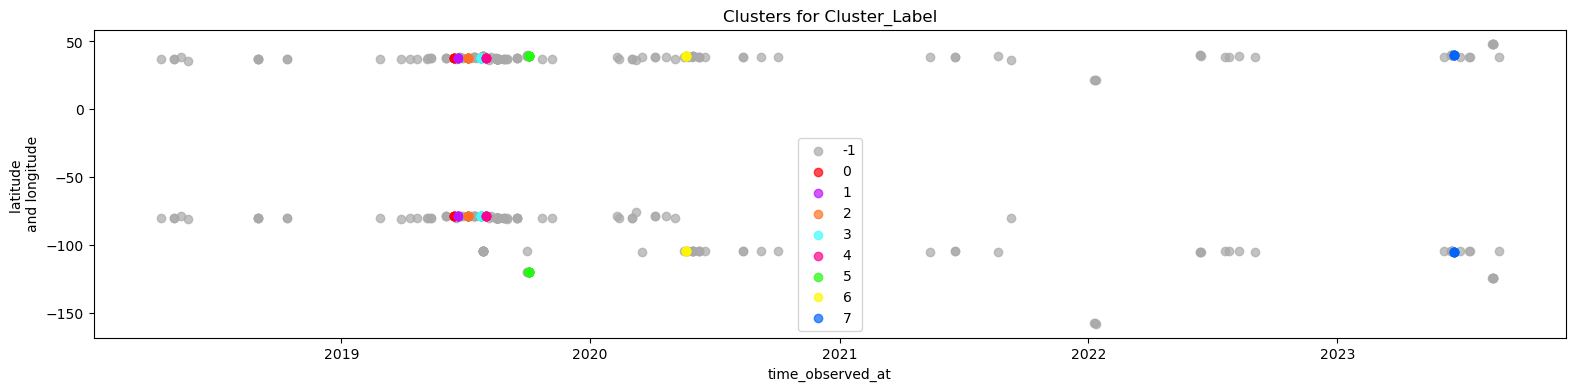

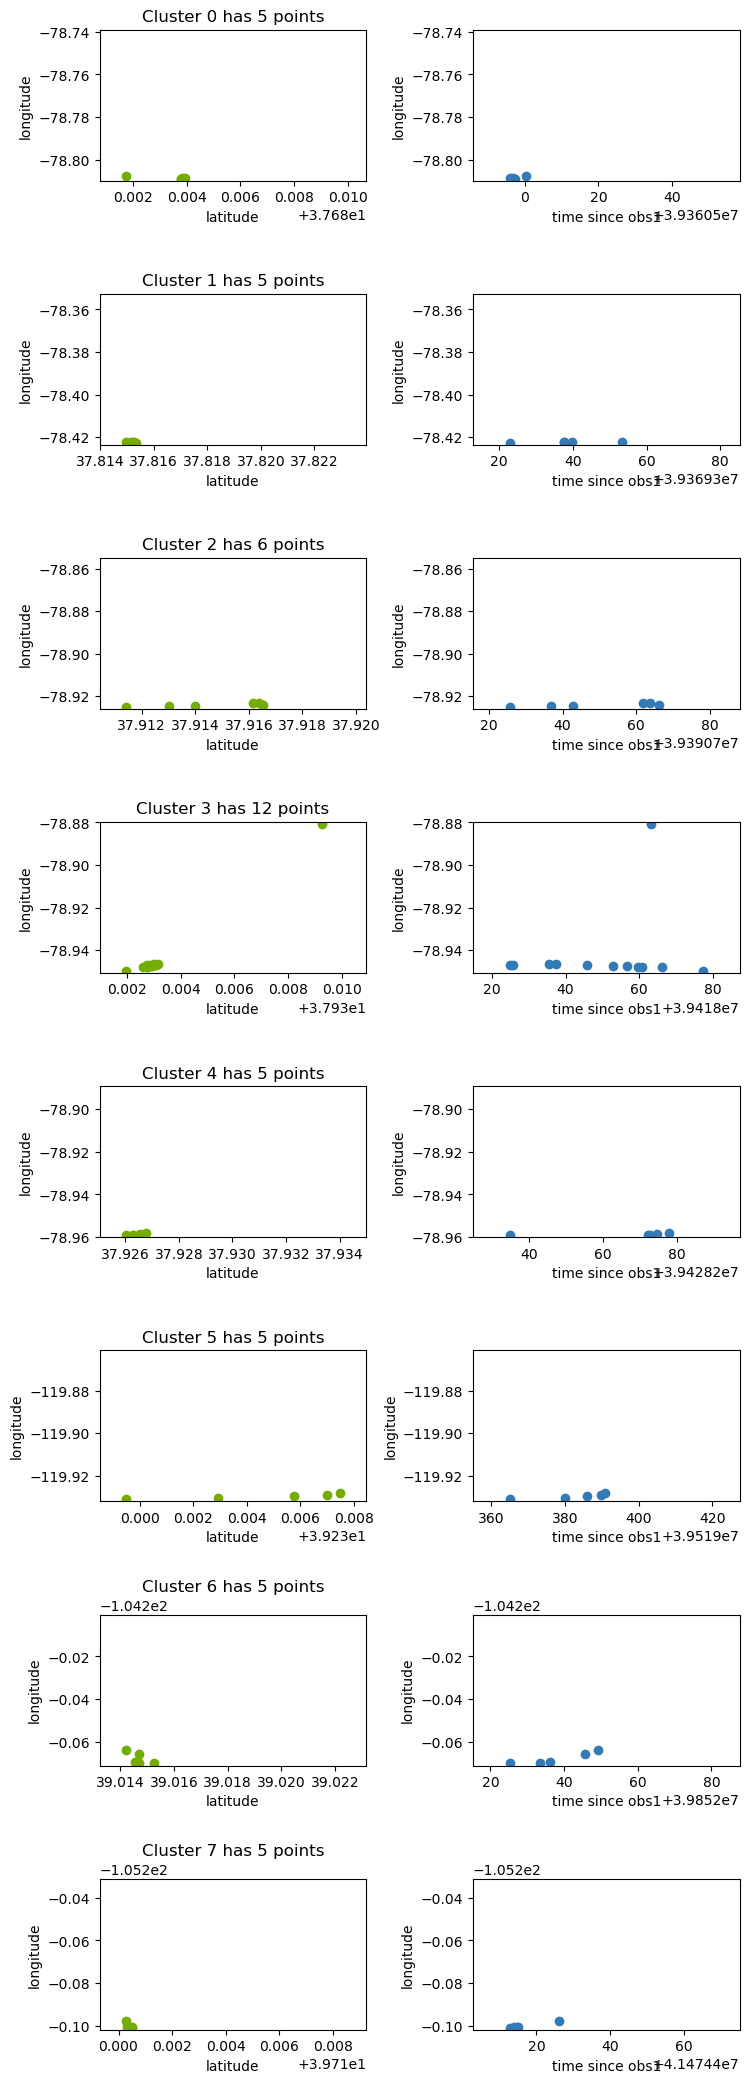

Artif_Cluster  Cluster_Label
22               4             -1
23               4              0
24               4              0
25               4              0
26               4              0
27               4              0
31               1             -1
32               1              1
33               1              1
34               1              1
35               1              1
36               1              1
41               9             -1
42               9             -1
43               9             -1
44               9             -1
45               9             -1
46               9              2
47               9              2
48               9              2
49               9              2
50               9              2
51               9              2
52               9             -1
53               9             -1
54               9             -1
62              10             -1
63              10             -1
64              10              3
65              10              3
66              10              3
67              10              3
68              10              3
69              10              3
70              10              3
71              10              3
72              10              3
73              10              3
74              10              3
75              10              3
76              10             -1
77              10             -1
78              10             -1
79              10             -1
80              10             -1
81              10             -1
82              10             -1
84               7             -1
85               7             -1
86               7             -1
87               7             -1
88               7             -1
89               7             -1
90               7             -1
91               7             -1
92               7             -1
93               7             -1
94               7             -1
96               5              4
97               5              4
98               5              4
99               5              4
100              5              4
101              5             -1
102              5             -1
103              5             -1
104              5             -1
110              6             -1
111              6             -1
112              6             -1
113              6             -1
114              6             -1
115              6             -1
116              6             -1
117              6             -1
118              6             -1
119              6             -1
139              8             -1
140              8             -1
141              8             -1
142              8             -1
143              8             -1
144              8             -1
145              8             -1
146              8              5
147              8              5
148              8              5
149              8              5
150              8              5
164              3             -1
165              3              6
166              3              6
167              3              6
168              3              6
169              3              6
201              0             -1
202              0             -1
203              0             -1
204              0             -1
205              0             -1
206              0             -1
210              2              7
211              2              7
212              2              7
213              2              7
214              2              7
215              2             -1

In [153]:
choose_a_model(5, .005, 5)

In [134]:
non_noise_df = rand_user_df[rand_user_df["Cluster_Label"] != -1]
fig = px.scatter_3d(non_noise_df, x='latitude', y='longitude', z='time_observed_at',
              color='Cluster_Label')
fig.show()

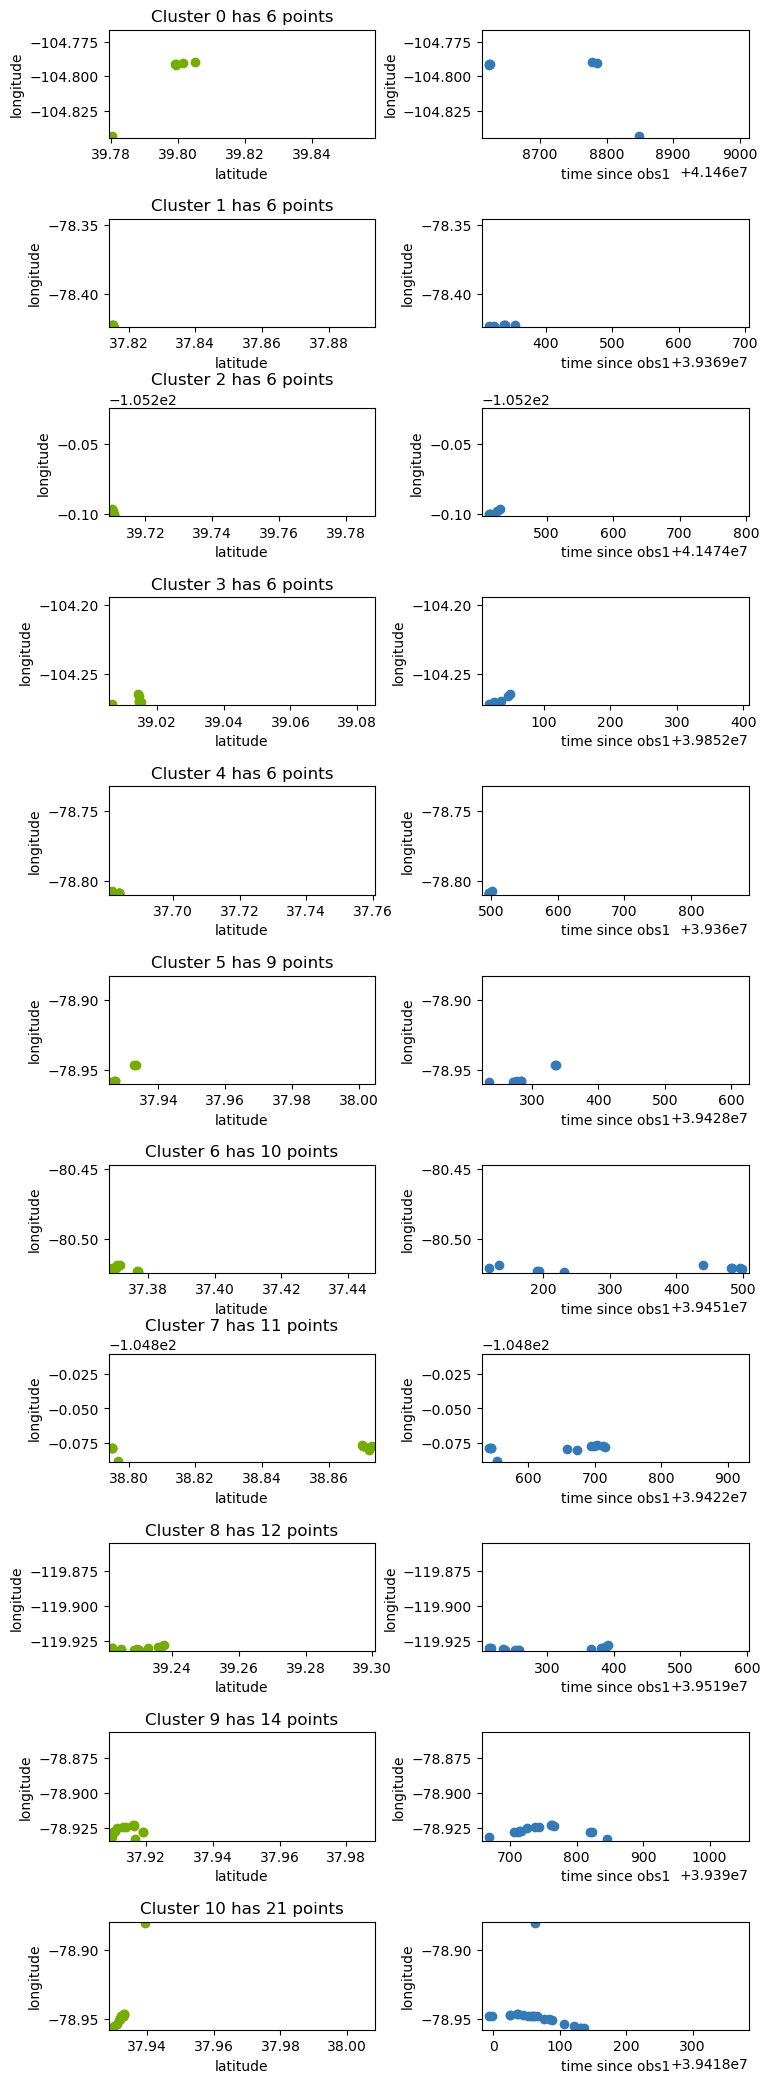

In [137]:
cluster_views("Artif_Cluster")

Every cluster the DBSCAN model found was also identified by my simple grouping by dates. However, the DBSCAN model was more discriminating, cutting off parts of the clusters from the day's observations that didn't fit into a well-defined cluster and dismissing other clusters that weren't as well-defined. This is exactly what I was looking for--an efficient way to more more precisely identify a well-defined "hike". 

## Data and Visualization for Sprint 2 Presentation<a id ="10"></a>

Plotting one of the "hikes" found by both the non ML model and the DBSCAN model--one that I agree is a good example of a hike.

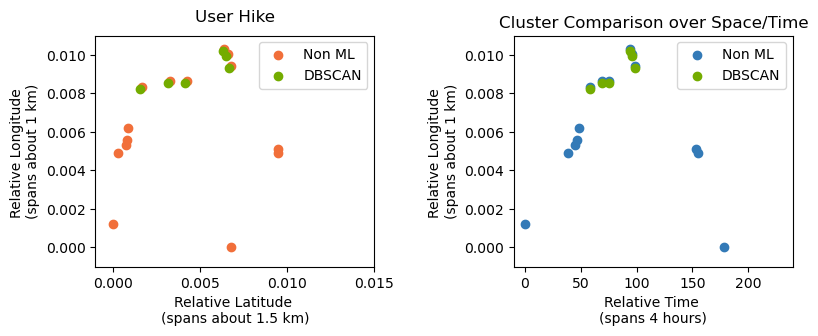

In [138]:

ind_1 = rand_user_df[rand_user_df["Artif_Cluster"] == 9]["latitude"]
x_1 = ind_1 - ind_1.min()
ind_2 = rand_user_df[rand_user_df["Artif_Cluster"] == 9]["obs_time_conv_(minutes)"]
x_2 = ind_2 - ind_2.min()
dep = rand_user_df[rand_user_df["Artif_Cluster"] == 9]["longitude"]
y = dep - dep.min()

indC_1 = rand_user_df[rand_user_df["Cluster_Label"] == 2]["latitude"]
xC_1 = indC_1 - ind_1.min() - .0001
indC_2 = rand_user_df[rand_user_df["Cluster_Label"] == 2]["obs_time_conv_(minutes)"]
xC_2 = indC_2 - ind_2.min() - .1
depC = rand_user_df[rand_user_df["Cluster_Label"] == 2]["longitude"]
yC = depC - dep.min() - .0001

plt.subplots(1, 2, figsize=(9, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
plt.scatter(x_1,y, c = '#f16f3a', label = "Non ML")
plt.scatter(xC_1,yC, c = '#74AC00', label = "DBSCAN")
plt.xlim(x_1.min()-.001, x_1.min() + .015)
plt.ylim(y.min()-.001, y.min() + .011)
plt.xlabel("Relative Latitude \n(spans about 1.5 km)")
plt.ylabel("Relative Longitude \n(spans about 1 km)")
plt.title("User Hike", pad = 10)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(x_2,y, c = '#337AB7', label = "Non ML")
plt.scatter(xC_2,yC, c = '#74AC00', label = "DBSCAN")
plt.xlim(x_2.min()-10, x_2.min() + 240)
plt.ylim(y.min()-.001, y.min() + .011)
plt.xlabel("Relative Time \n(spans 4 hours)")
plt.ylabel("Relative Longitude \n(spans about 1 km)")
plt.title("Cluster Comparison over Space/Time")
plt.legend()



plt.show()

In [139]:
# finding the url links that correspond to this hike
rand_user_df[rand_user_df["Artif_Cluster"] == 9][["url", "latitude", "longitude", "taxon_kingdom_name"]]

url   latitude  longitude  \
41  https://www.inaturalist.org/observations/28244146  37.909758 -78.932062   
42  https://www.inaturalist.org/observations/28244249  37.910053 -78.928375   
43  https://www.inaturalist.org/observations/28244430  37.910488 -78.927963   
44  https://www.inaturalist.org/observations/28244468  37.910580 -78.927712   
45  https://www.inaturalist.org/observations/28244513  37.910605 -78.927055   
46  https://www.inaturalist.org/observations/28244543  37.911433 -78.924920   
47  https://www.inaturalist.org/observations/28244571  37.913025 -78.924645   
48  https://www.inaturalist.org/observations/28244611  37.914003 -78.924645   
49  https://www.inaturalist.org/observations/28244664  37.916162 -78.922958   
50  https://www.inaturalist.org/observations/28244739  37.916367 -78.923247   
51  https://www.inaturalist.org/observations/28244881  37.916530 -78.923837   
52  https://www.inaturalist.org/observations/28244930  37.919205 -78.928153   
53  https://www.inaturalist.org/observations/28244988  37.919230 -78.928367   
54  https://www.inaturalist.org/observations/28245026  37.916553 -78.933267   

   taxon_kingdom_name  
41            Plantae  
42            Plantae  
43            Plantae  
44            Plantae  
45            Plantae  
46            Plantae  
47            Plantae  
48            Plantae  
49            Plantae  
50            Plantae  
51            Plantae  
52            Plantae  
53            Plantae  
54              Fungi

While the DBSCAN model found the same "hike"--it defined it so narrowly as to cut out information that was likely part of the hike. So the non ML model is non discriminating enough while the highest performing DBSCAN model is too discriminating. It will be worth looking at sil scores that fall between the two to see if I can find the "goldilocks" version. 

## Goldilocks
Since the "best" performing models by sil score are too strict I'm looking at how the "next best" perform. I'm particularly interested in those models with relative scores that are better than the baseline relative scores.

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\1880991399.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



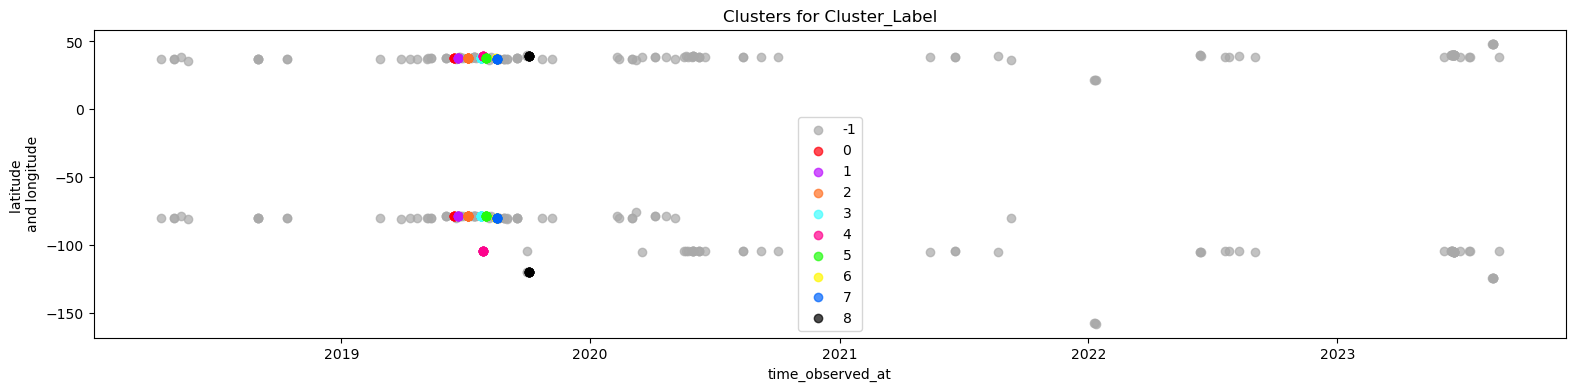

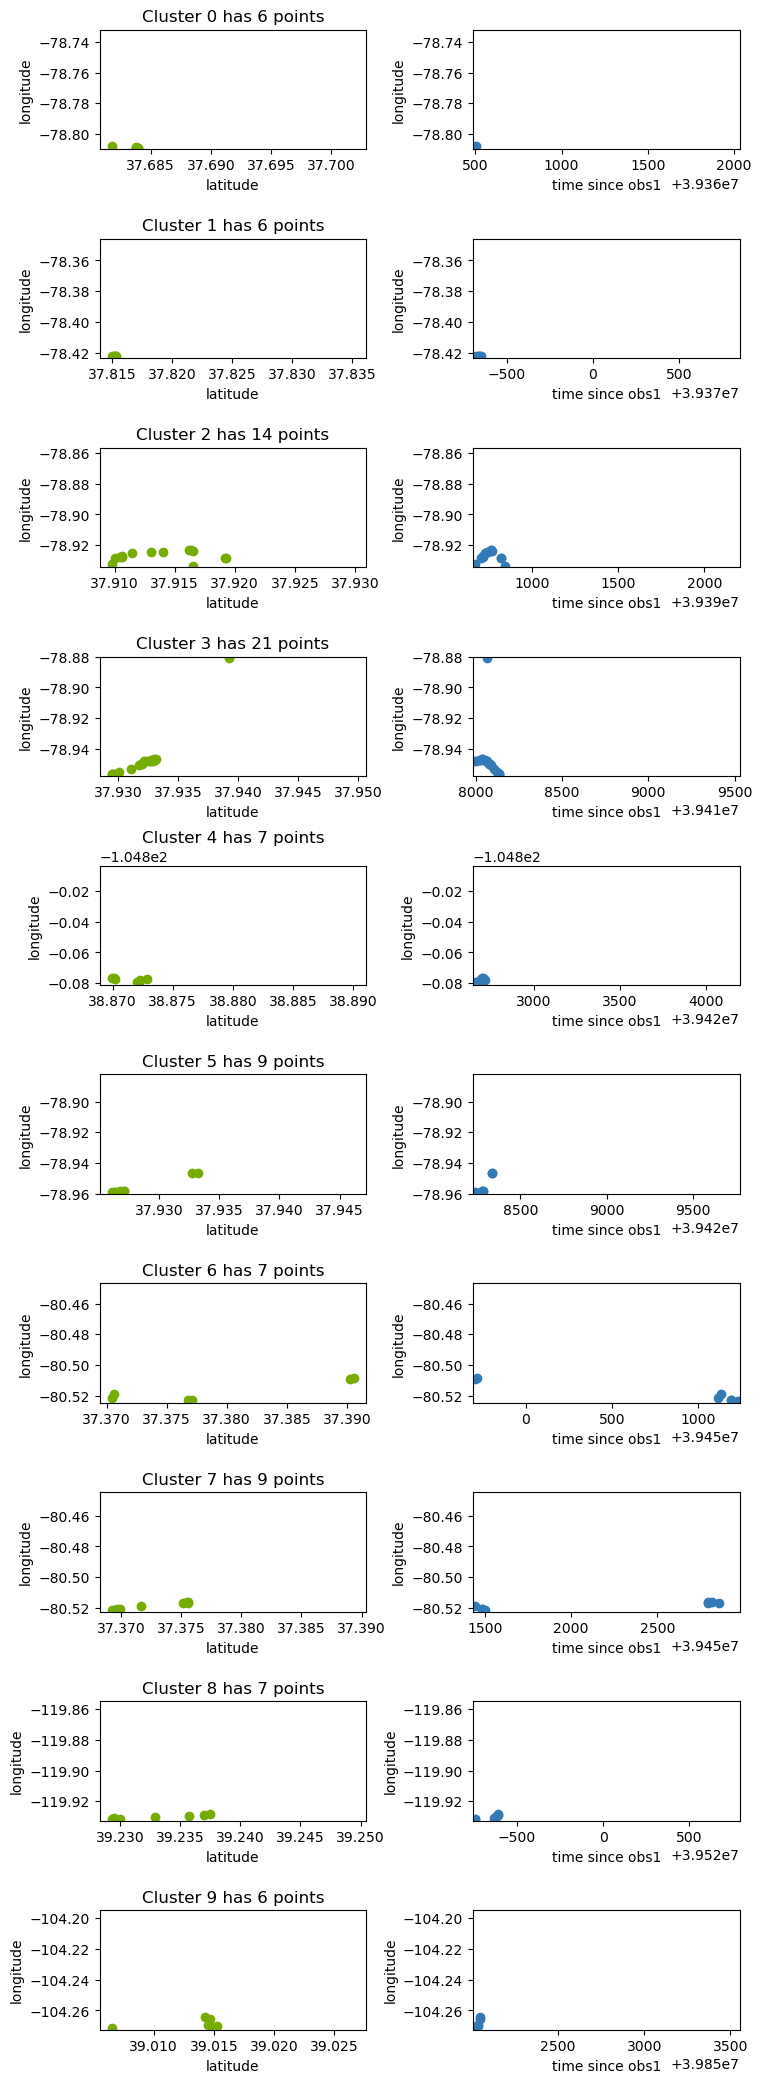

Artif_Cluster  Cluster_Label
22               4              0
23               4              0
24               4              0
25               4              0
26               4              0
27               4              0
31               1              1
32               1              1
33               1              1
34               1              1
35               1              1
36               1              1
41               9              2
42               9              2
43               9              2
44               9              2
45               9              2
46               9              2
47               9              2
48               9              2
49               9              2
50               9              2
51               9              2
52               9              2
53               9              2
54               9              2
62              10              3
63              10              3
64              10              3
65              10              3
66              10              3
67              10              3
68              10              3
69              10              3
70              10              3
71              10              3
72              10              3
73              10              3
74              10              3
75              10              3
76              10              3
77              10              3
78              10              3
79              10              3
80              10              3
81              10              3
82              10              3
84               7             -1
85               7             -1
86               7             -1
87               7             -1
88               7              4
89               7              4
90               7              4
91               7              4
92               7              4
93               7              4
94               7              4
96               5              5
97               5              5
98               5              5
99               5              5
100              5              5
101              5              5
102              5              5
103              5              5
104              5              5
108             -1              6
109             -1              6
110              6              6
111              6              6
112              6              6
113              6              6
114              6              6
115              6              7
116              6              7
117              6              7
118              6              7
119              6              7
120             -1              7
121             -1              7
122             -1              7
123             -1              7
139              8             -1
140              8             -1
141              8             -1
142              8             -1
143              8             -1
144              8              8
145              8              8
146              8              8
147              8              8
148              8              8
149              8              8
150              8              8
164              3              9
165              3              9
166              3              9
167              3              9
168              3              9
169              3              9
201              0             -1
202              0             -1
203              0             -1
204              0             -1
205              0             -1
206              0             -1
210              2             -1
211              2             -1
212              2             -1
213              2             -1
214              2             -1
215              2             -1

In [157]:
choose_a_model(2, .1, 6)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\1880991399.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



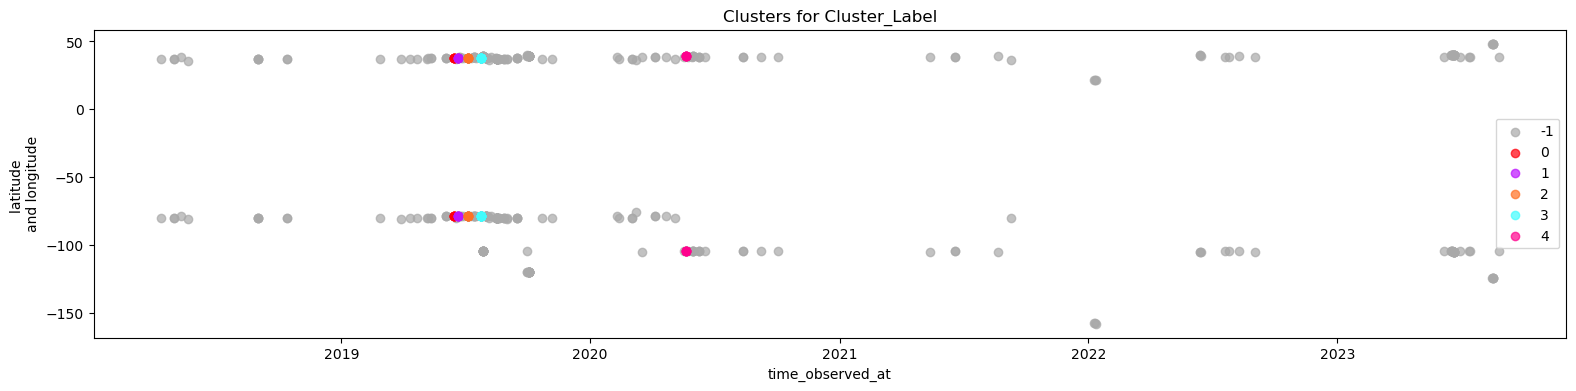

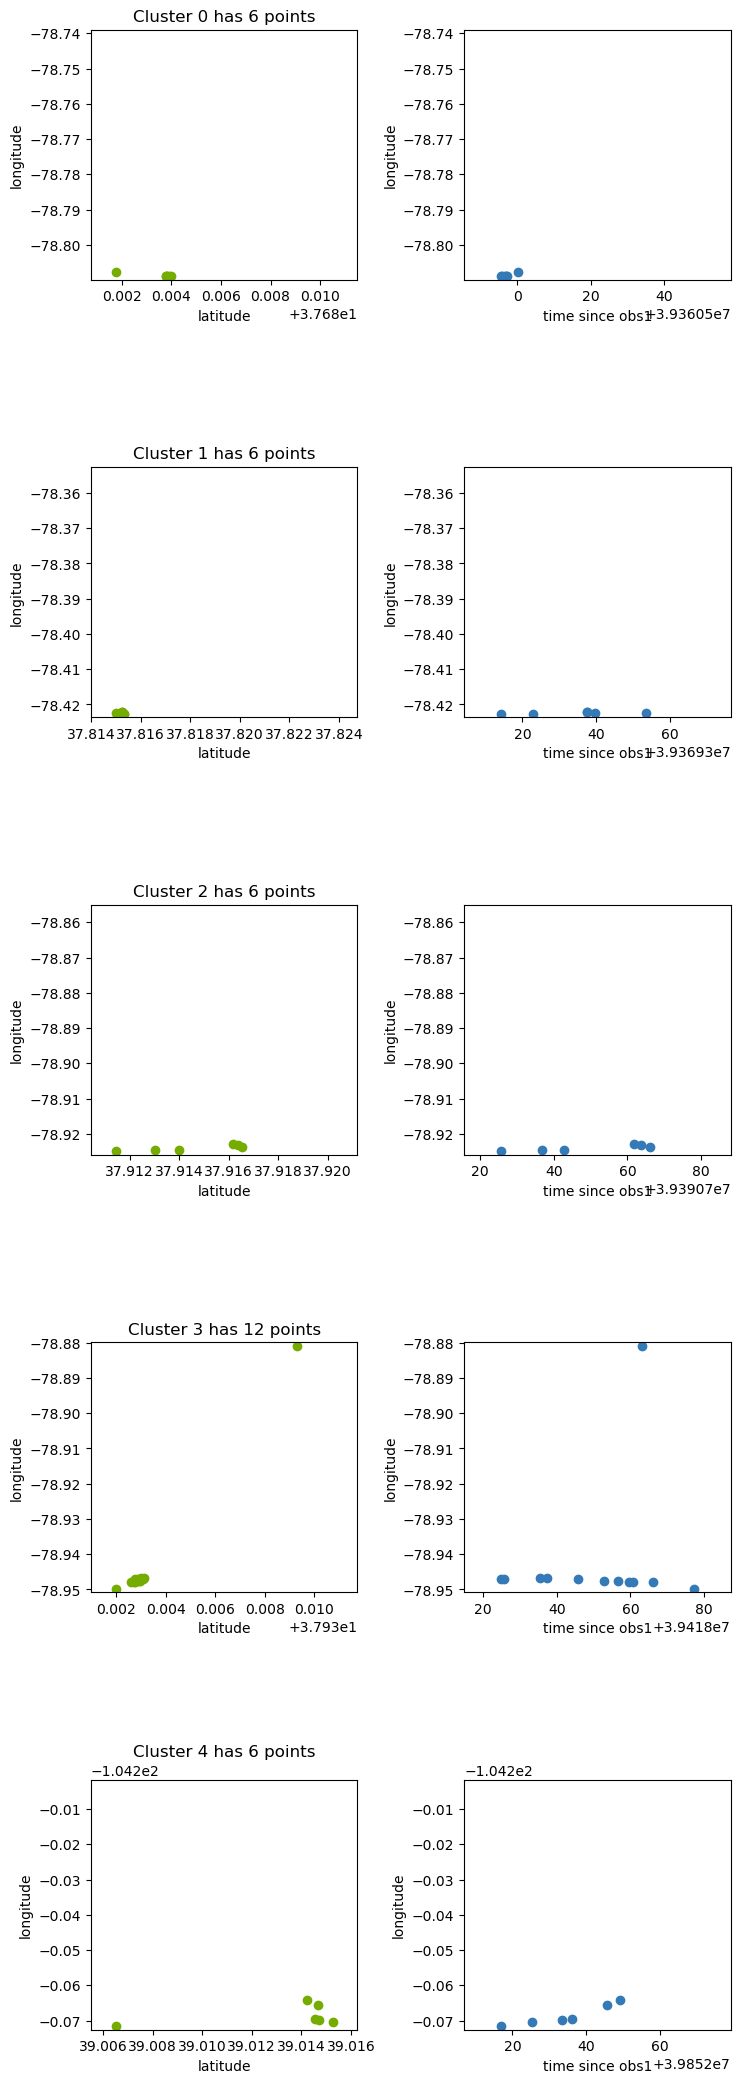

Artif_Cluster  Cluster_Label
22               4              0
23               4              0
24               4              0
25               4              0
26               4              0
27               4              0
31               1              1
32               1              1
33               1              1
34               1              1
35               1              1
36               1              1
41               9             -1
42               9             -1
43               9             -1
44               9             -1
45               9             -1
46               9              2
47               9              2
48               9              2
49               9              2
50               9              2
51               9              2
52               9             -1
53               9             -1
54               9             -1
62              10             -1
63              10             -1
64              10              3
65              10              3
66              10              3
67              10              3
68              10              3
69              10              3
70              10              3
71              10              3
72              10              3
73              10              3
74              10              3
75              10              3
76              10             -1
77              10             -1
78              10             -1
79              10             -1
80              10             -1
81              10             -1
82              10             -1
84               7             -1
85               7             -1
86               7             -1
87               7             -1
88               7             -1
89               7             -1
90               7             -1
91               7             -1
92               7             -1
93               7             -1
94               7             -1
96               5             -1
97               5             -1
98               5             -1
99               5             -1
100              5             -1
101              5             -1
102              5             -1
103              5             -1
104              5             -1
110              6             -1
111              6             -1
112              6             -1
113              6             -1
114              6             -1
115              6             -1
116              6             -1
117              6             -1
118              6             -1
119              6             -1
139              8             -1
140              8             -1
141              8             -1
142              8             -1
143              8             -1
144              8             -1
145              8             -1
146              8             -1
147              8             -1
148              8             -1
149              8             -1
150              8             -1
164              3              4
165              3              4
166              3              4
167              3              4
168              3              4
169              3              4
201              0             -1
202              0             -1
203              0             -1
204              0             -1
205              0             -1
206              0             -1
210              2             -1
211              2             -1
212              2             -1
213              2             -1
214              2             -1
215              2             -1

In [156]:
choose_a_model(2, .01, 6)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\1880991399.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



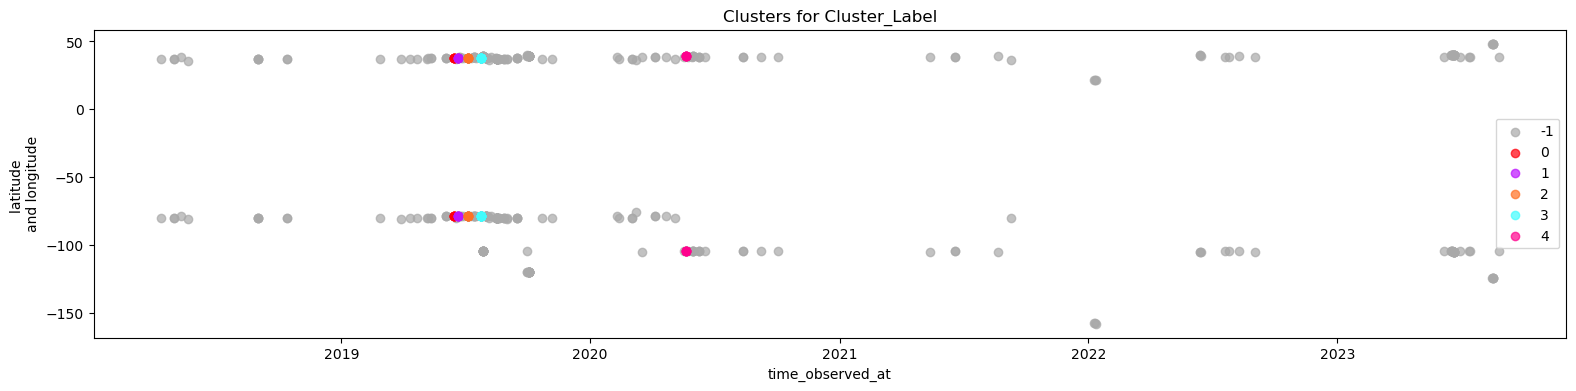

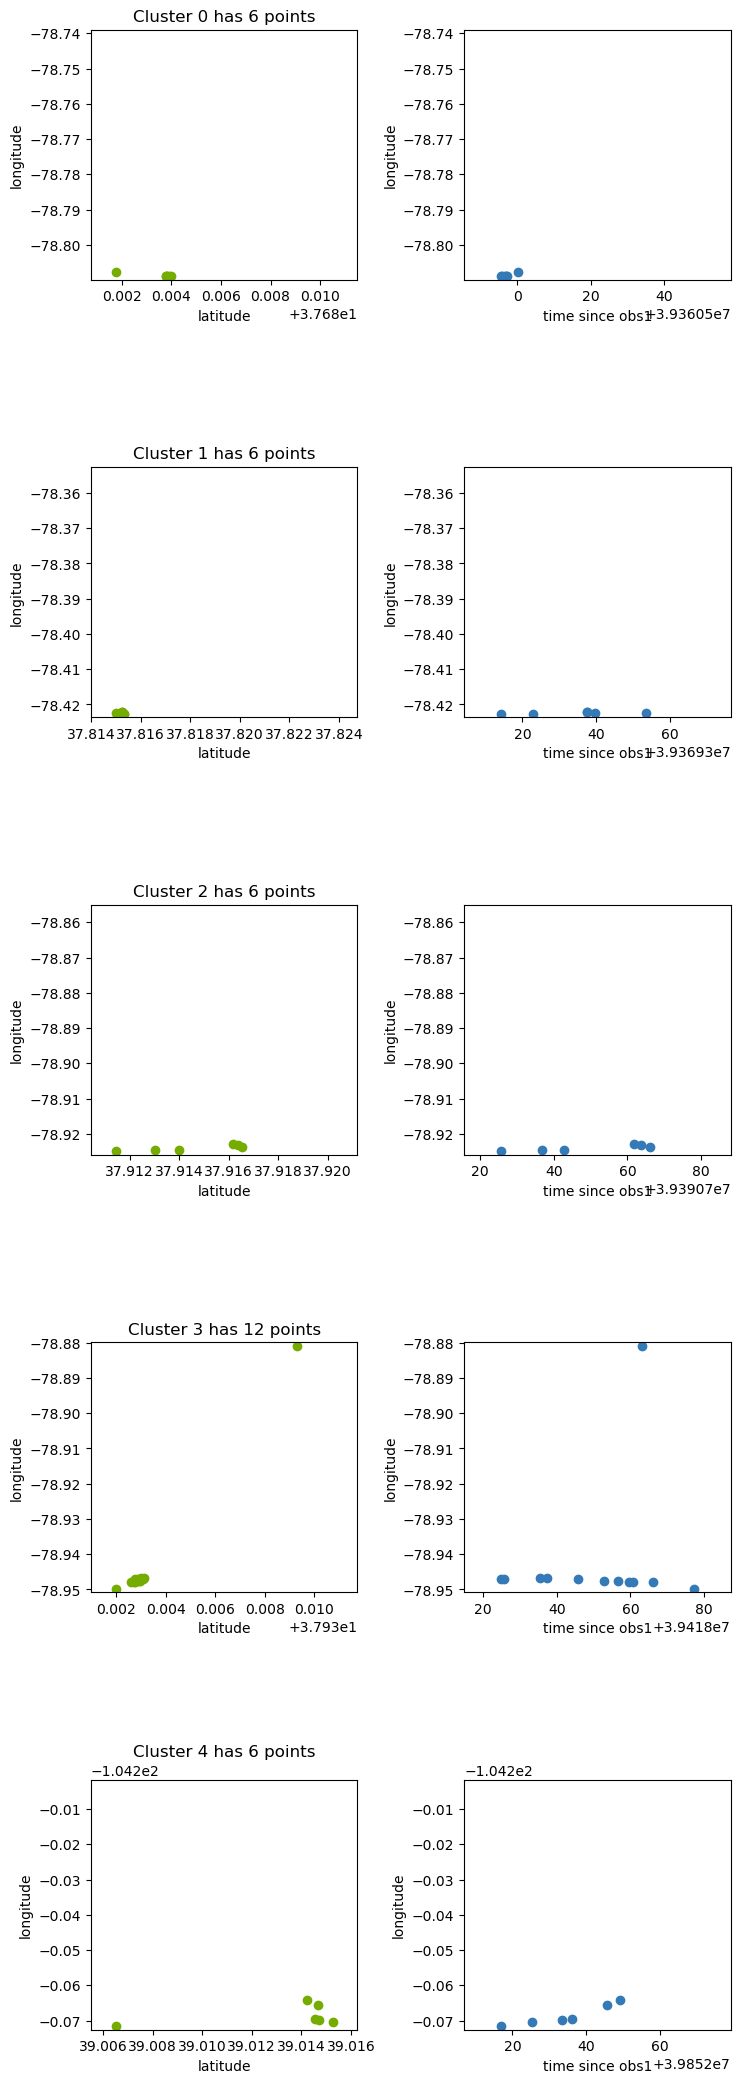

Artif_Cluster  Cluster_Label
22               4              0
23               4              0
24               4              0
25               4              0
26               4              0
27               4              0
31               1              1
32               1              1
33               1              1
34               1              1
35               1              1
36               1              1
41               9             -1
42               9             -1
43               9             -1
44               9             -1
45               9             -1
46               9              2
47               9              2
48               9              2
49               9              2
50               9              2
51               9              2
52               9             -1
53               9             -1
54               9             -1
62              10             -1
63              10             -1
64              10              3
65              10              3
66              10              3
67              10              3
68              10              3
69              10              3
70              10              3
71              10              3
72              10              3
73              10              3
74              10              3
75              10              3
76              10             -1
77              10             -1
78              10             -1
79              10             -1
80              10             -1
81              10             -1
82              10             -1
84               7             -1
85               7             -1
86               7             -1
87               7             -1
88               7             -1
89               7             -1
90               7             -1
91               7             -1
92               7             -1
93               7             -1
94               7             -1
96               5             -1
97               5             -1
98               5             -1
99               5             -1
100              5             -1
101              5             -1
102              5             -1
103              5             -1
104              5             -1
110              6             -1
111              6             -1
112              6             -1
113              6             -1
114              6             -1
115              6             -1
116              6             -1
117              6             -1
118              6             -1
119              6             -1
139              8             -1
140              8             -1
141              8             -1
142              8             -1
143              8             -1
144              8             -1
145              8             -1
146              8             -1
147              8             -1
148              8             -1
149              8             -1
150              8             -1
164              3              4
165              3              4
166              3              4
167              3              4
168              3              4
169              3              4
201              0             -1
202              0             -1
203              0             -1
204              0             -1
205              0             -1
206              0             -1
210              2             -1
211              2             -1
212              2             -1
213              2             -1
214              2             -1
215              2             -1

In [155]:
choose_a_model(2, .005, 6)

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\1880991399.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



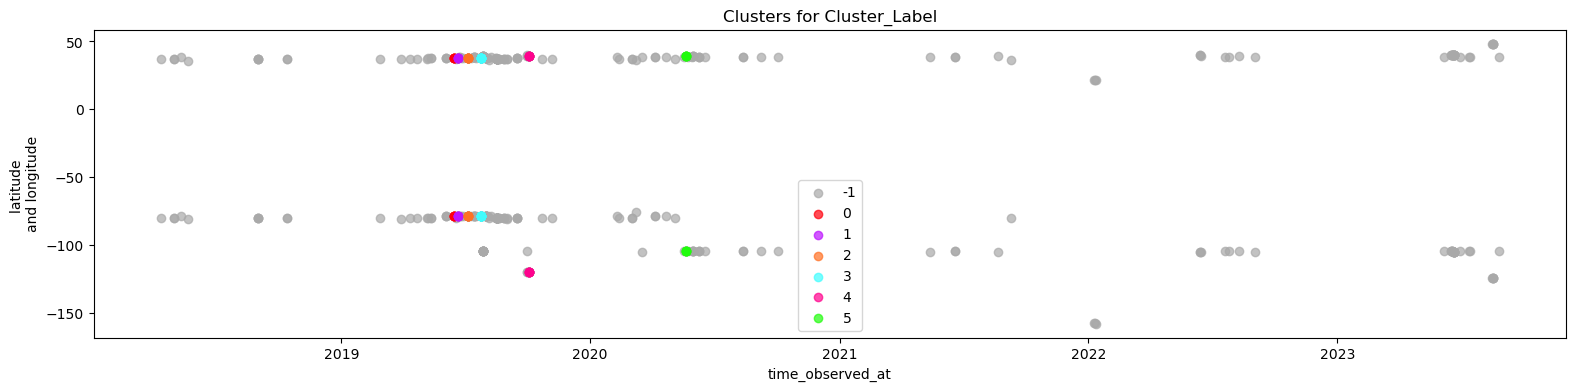

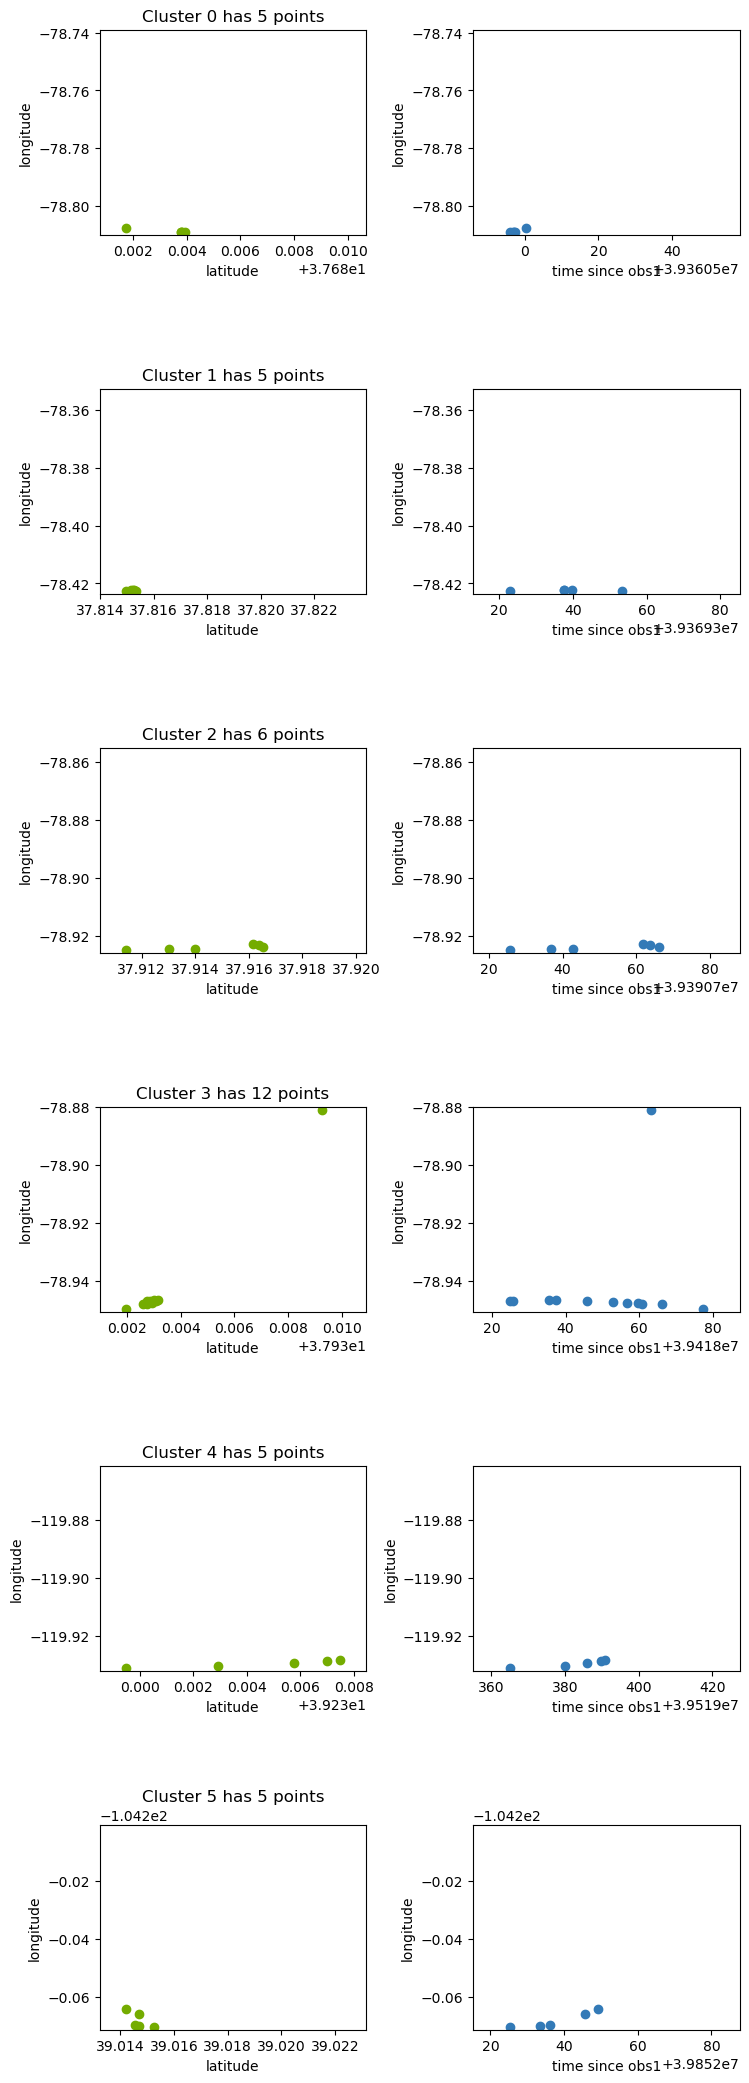

Artif_Cluster  Cluster_Label
22               4             -1
23               4              0
24               4              0
25               4              0
26               4              0
27               4              0
31               1             -1
32               1              1
33               1              1
34               1              1
35               1              1
36               1              1
41               9             -1
42               9             -1
43               9             -1
44               9             -1
45               9             -1
46               9              2
47               9              2
48               9              2
49               9              2
50               9              2
51               9              2
52               9             -1
53               9             -1
54               9             -1
62              10             -1
63              10             -1
64              10              3
65              10              3
66              10              3
67              10              3
68              10              3
69              10              3
70              10              3
71              10              3
72              10              3
73              10              3
74              10              3
75              10              3
76              10             -1
77              10             -1
78              10             -1
79              10             -1
80              10             -1
81              10             -1
82              10             -1
84               7             -1
85               7             -1
86               7             -1
87               7             -1
88               7             -1
89               7             -1
90               7             -1
91               7             -1
92               7             -1
93               7             -1
94               7             -1
96               5             -1
97               5             -1
98               5             -1
99               5             -1
100              5             -1
101              5             -1
102              5             -1
103              5             -1
104              5             -1
110              6             -1
111              6             -1
112              6             -1
113              6             -1
114              6             -1
115              6             -1
116              6             -1
117              6             -1
118              6             -1
119              6             -1
139              8             -1
140              8             -1
141              8             -1
142              8             -1
143              8             -1
144              8             -1
145              8             -1
146              8              4
147              8              4
148              8              4
149              8              4
150              8              4
164              3             -1
165              3              5
166              3              5
167              3              5
168              3              5
169              3              5
201              0             -1
202              0             -1
203              0             -1
204              0             -1
205              0             -1
206              0             -1
210              2             -1
211              2             -1
212              2             -1
213              2             -1
214              2             -1
215              2             -1

In [158]:
choose_a_model(7, .001, 5)

For 2, .1, 6: This kept the entire hike found by Artificial Cluster 9 and rejected Artifical Cluster 0 and 2--all of which are good! But it did a very weird thing to artificial cluster 6--breaking it up (which is reasonable) but then adding more to it and allowing the two new clusters to span 1000 minutes which doesn't make sense. Wondering if adding "minute_diff" would help? 

For 2, .01, 6: Too strict

Based off my thoughts for 2, .1, 6--I added an 8th feature selection which was feature group 2 plus "minute_diff" (feature group 7), then reran the code. 7 did well in the "absolute silhouette score" category but not the other two and its relative scores were low (although often higher than the baseline). 

For 7, .001, 5: Too strict

Arggh--other than this kind of hackjob of external validation I'm doing, there's not sound statistical reason to choose a model that performs more poorly than the baseline
I'm wondering if there are things that unsupervised could ADD to that baseline.

Something like:
1) Make the baseline model (but with better attention to timezones)
2) Perform kmeans and/or dbscan on just the minute_diff and km_diff and see if that clustering can REFINE the baseline model

Step 1 can be put in the next level of scaling up, but for here I'll skip it for time's sake just to see if the step 2 refine part is useful:

In [161]:
kmeans_df = rand_user_df[["minute_diff", 'km_diff']]
# scale data --choosing StandardScaler this time, might try MinMax later
sts = StandardScaler()
kmeans_df_scaled = sts.fit_transform(kmeans_df)

#instantiate model
kmeans_model = KMeans(n_clusters = 2, max_iter = 1000, random_state = 1114)
#choosing only 2 clusters because I'm hoping to find the range of time/dist differences that indicate TOGETHER vs NOT

cluster_labels = kmeans_model.fit_predict(kmeans_df_scaled)
rand_user_df["KMeans_Label"] = cluster_labels


C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\lisa_\AppData\Local\Temp\ipykernel_73540\1688073654.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



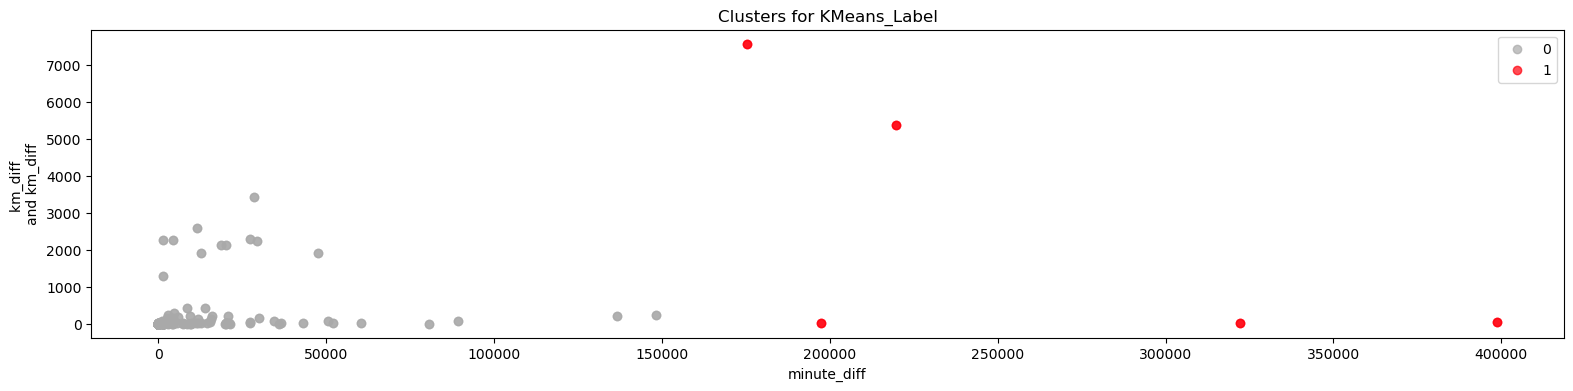

In [162]:
cluster_overview("KMeans_Label", x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

This first attempt allows a minute difference of up to 150000, which makes no sense for my model.
I wonder if this would be better done on the larger set.

In [163]:
kmeans_df_big = df_sp[["minute_diff", 'km_diff']]
# scale data --choosing StandardScaler this time, might try MinMax later
sts = StandardScaler()
kmeans_df_big_scaled = sts.fit_transform(kmeans_df_big)

#instantiate model
kmeans_big_model = KMeans(n_clusters = 2, max_iter = 1000, random_state = 1114)
#choosing only 2 clusters because I'm hoping to find the range of time/dist differences that indicate TOGETHER vs NOT

cluster_labels = kmeans_big_model.fit_predict(kmeans_df_big_scaled)
df_sp["KMeans_Label"] = cluster_labels

C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



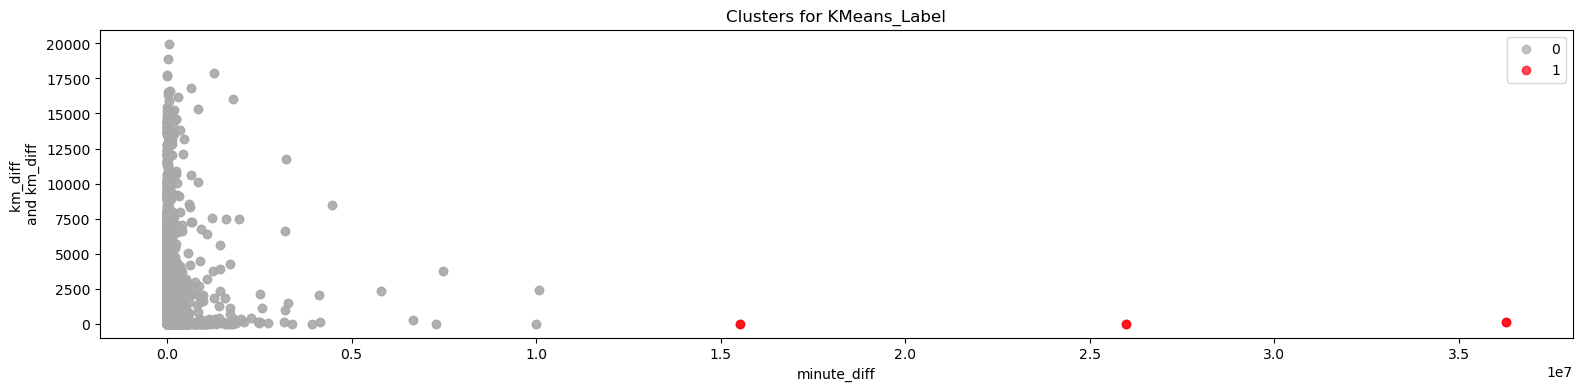

In [164]:
cluster_overview("KMeans_Label", df = df_sp, x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

In [166]:
df_sp["KMeans_Label"].value_counts()

0    1050148
1          3
Name: KMeans_Label, dtype: int64

Absolutely not. Probably still needs DBSCAN to allow for noise. But I can try again with maybe 10 groups?

C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



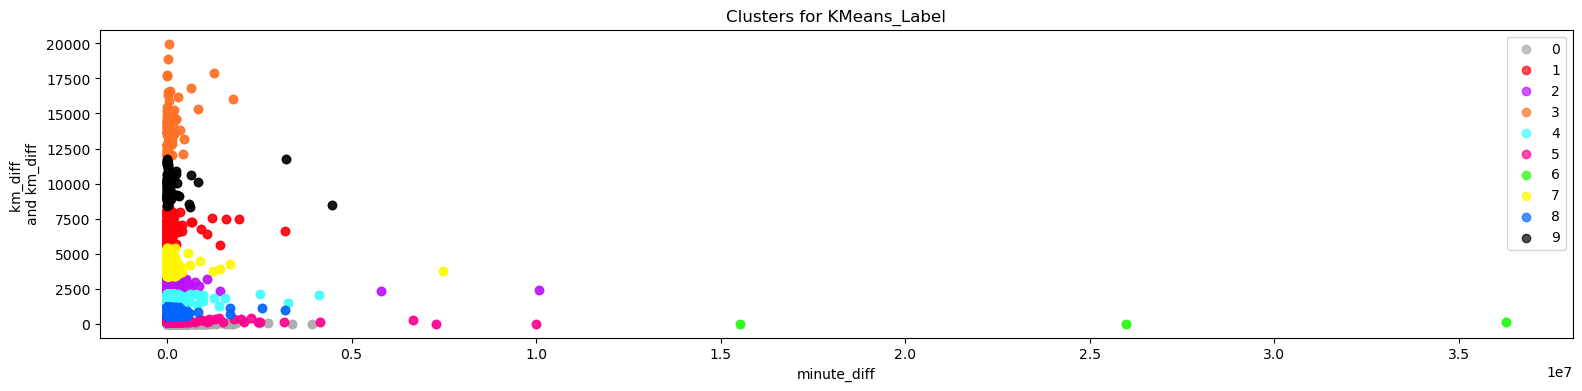

0    1030796
5      13652
8       2275
4       1536
2        918
7        500
1        262
3        107
9        102
6          3
Name: KMeans_Label, dtype: int64

In [178]:
kmeans_df_big = df_sp[["minute_diff", 'km_diff']]
# scale data --choosing StandardScaler this time, might try MinMax later
mms = MinMaxScaler()
kmeans_df_big_scaled = mms.fit_transform(kmeans_df_big)

#instantiate model
kmeans_big_model = KMeans(n_clusters = 10, max_iter = 1000, random_state = 1114)
#choosing only 2 clusters because I'm hoping to find the range of time/dist differences that indicate TOGETHER vs NOT

cluster_labels = kmeans_big_model.fit_predict(kmeans_df_big_scaled)
df_sp["KMeans_Label"] = cluster_labels
cluster_overview("KMeans_Label", df = df_sp, x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

df_sp["KMeans_Label"].value_counts()

In [179]:
round(df_sp[df_sp["KMeans_Label"] == 0][["km_diff", "minute_diff"]].describe(),0)

km_diff  minute_diff
count  1030796.0    1030796.0
mean         4.0        704.0
std         12.0      12960.0
min         -0.0         -0.0
25%          0.0          1.0
50%          0.0          3.0
75%          0.0         14.0
max        120.0    3927557.0

Nope. Doesn't matter for scaling type or 5 or 10 clusters. (although interestingly MinMaxScaler created something that looked like horizontal slices)
What if I kept the time less than 24 hours and km less than 50 km in the database? And then clustered on that?

In [184]:
limited_kmeans_df = df_sp[(df_sp["minute_diff"]< (24*60)) & (df_sp["km_diff"]< (50))][["minute_diff", 'km_diff']]
limited_kmeans_df.shape

(966501, 2)

C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



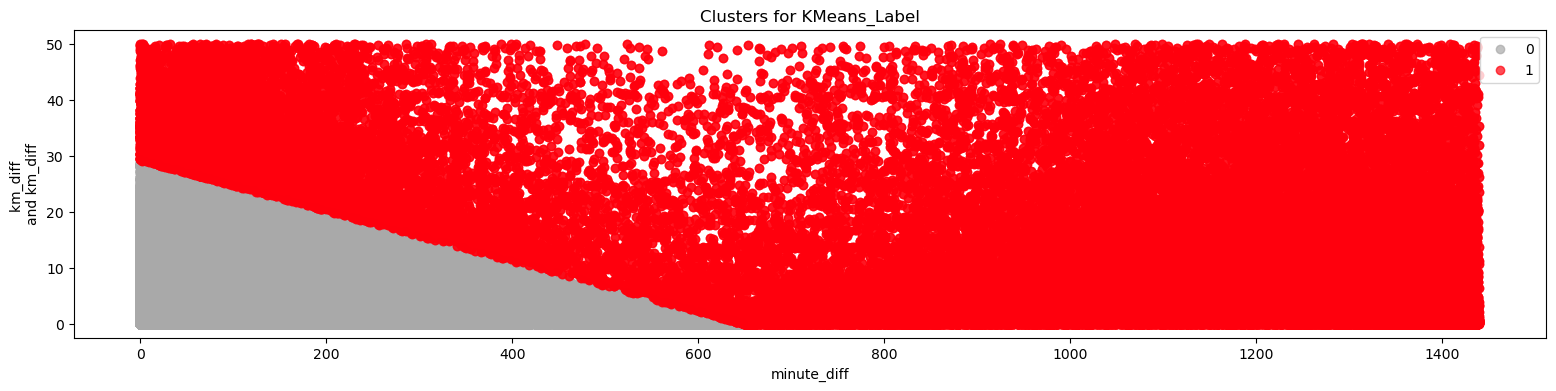

0    921880
1     44621
Name: KMeans_Label, dtype: int64

In [185]:

# scale data --choosing StandardScaler this time, might try MinMax later
sts = StandardScaler()
limited_kmeans_df_scaled = sts.fit_transform(limited_kmeans_df)

#instantiate model
limited_kmeans_model = KMeans(n_clusters = 2, max_iter = 1000, random_state = 1114)
#choosing only 2 clusters because I'm hoping to find the range of time/dist differences that indicate TOGETHER vs NOT

cluster_labels = limited_kmeans_model.fit_predict(limited_kmeans_df_scaled)
limited_kmeans_df["KMeans_Label"] = cluster_labels
cluster_overview("KMeans_Label", df = limited_kmeans_df, x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

limited_kmeans_df["KMeans_Label"].value_counts()

Well that looks better but also arbitary from this point of view although there could be a gap we can't see at that line?

C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



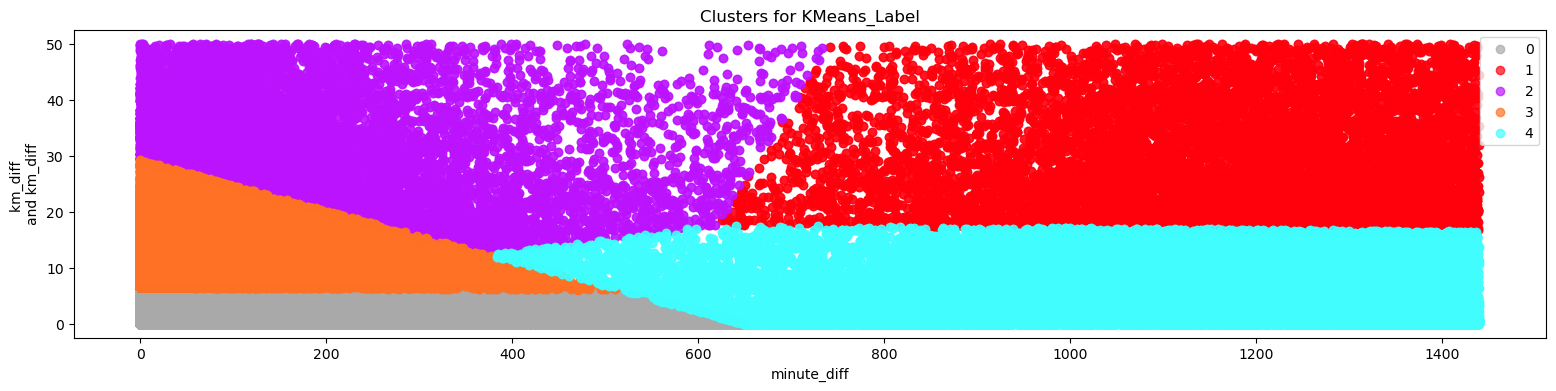

0    845952
3     75928
4     26601
2      9025
1      8995
Name: KMeans_Label, dtype: int64

In [186]:
# scale data --choosing StandardScaler this time, might try MinMax later
sts = StandardScaler()
limited_kmeans_df_scaled = sts.fit_transform(limited_kmeans_df)

#instantiate model
limited_kmeans_model = KMeans(n_clusters = 5, max_iter = 1000, random_state = 1114)
#choosing only 2 clusters because I'm hoping to find the range of time/dist differences that indicate TOGETHER vs NOT

cluster_labels = limited_kmeans_model.fit_predict(limited_kmeans_df_scaled)
limited_kmeans_df["KMeans_Label"] = cluster_labels
cluster_overview("KMeans_Label", df = limited_kmeans_df, x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

limited_kmeans_df["KMeans_Label"].value_counts()

Still that one line but other sections are then parsed on it.

C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



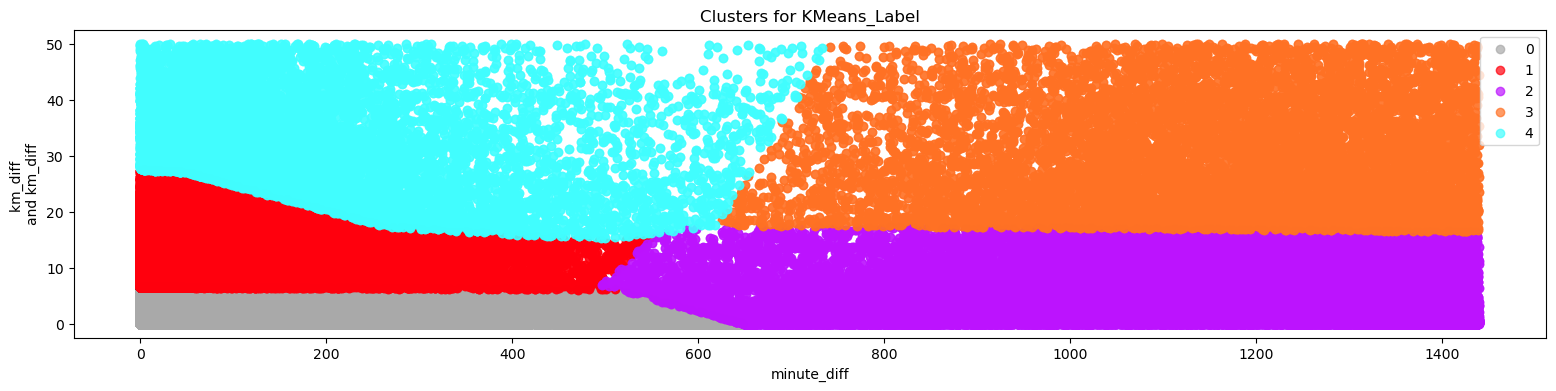

0    845952
1     76314
2     26339
3      8995
4      8901
Name: KMeans_Label, dtype: int64

In [187]:
# scale data --choosing StandardScaler this time, might try MinMax later
mms = MinMaxScaler()
limited_kmeans_df_scaled = mms.fit_transform(limited_kmeans_df)

#instantiate model
limited_kmeans_model = KMeans(n_clusters = 5, max_iter = 1000, random_state = 1114)
#choosing only 2 clusters because I'm hoping to find the range of time/dist differences that indicate TOGETHER vs NOT

cluster_labels = limited_kmeans_model.fit_predict(limited_kmeans_df_scaled)
limited_kmeans_df["KMeans_Label"] = cluster_labels
cluster_overview("KMeans_Label", df = limited_kmeans_df, x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

limited_kmeans_df["KMeans_Label"].value_counts()

Again, MinMaxScaler produces more horizontal type groupings.

C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



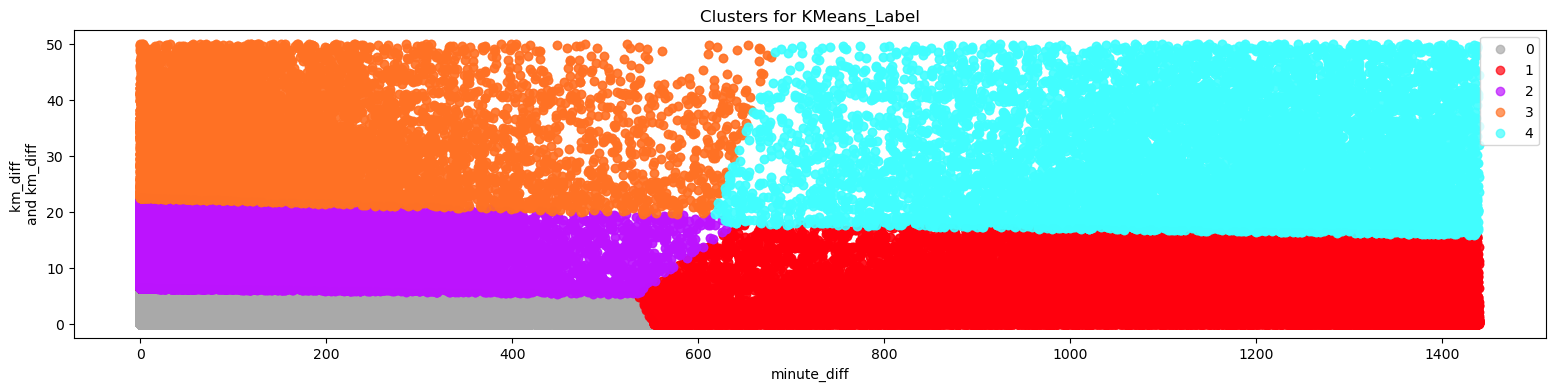

0    842918
2     76859
1     27175
3     10302
4      9247
Name: KMeans_Label, dtype: int64

In [188]:
# scale data --choosing StandardScaler this time, might try MinMax later
rss = RobustScaler()
limited_kmeans_df_scaled = rss.fit_transform(limited_kmeans_df)

#instantiate model
limited_kmeans_model = KMeans(n_clusters = 5, max_iter = 1000, random_state = 1114)
#choosing only 2 clusters because I'm hoping to find the range of time/dist differences that indicate TOGETHER vs NOT

cluster_labels = limited_kmeans_model.fit_predict(limited_kmeans_df_scaled)
limited_kmeans_df["KMeans_Label"] = cluster_labels
cluster_overview("KMeans_Label", df = limited_kmeans_df, x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

limited_kmeans_df["KMeans_Label"].value_counts()

Robustscaler does an even block-ier grouping with horizontal and vertical blocks.

In [200]:
# # scale data --choosing StandardScaler this time, might try MinMax later
# mms = MinMaxScaler()
# limited_kmeans_df_scaled = mms.fit_transform(limited_kmeans_df)

# #instantiate model
# limited_dbscan_model = DBSCAN(eps=.01, min_samples = 50)

# cluster_labels = limited_dbscan_model.fit_predict(limited_kmeans_df_scaled)
# limited_kmeans_df["DBSCAN_Label"] = cluster_labels
# cluster_overview("DBSCAN_Label", df = limited_kmeans_df, x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

# limited_kmeans_df["DBSCAN_Label"].value_counts()

In [191]:
limited_kmeans_df = df_sp[(df_sp["minute_diff"]< 240) & (df_sp["km_diff"]< (5))][["minute_diff", 'km_diff']]
limited_kmeans_df.shape

(825774, 2)

C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



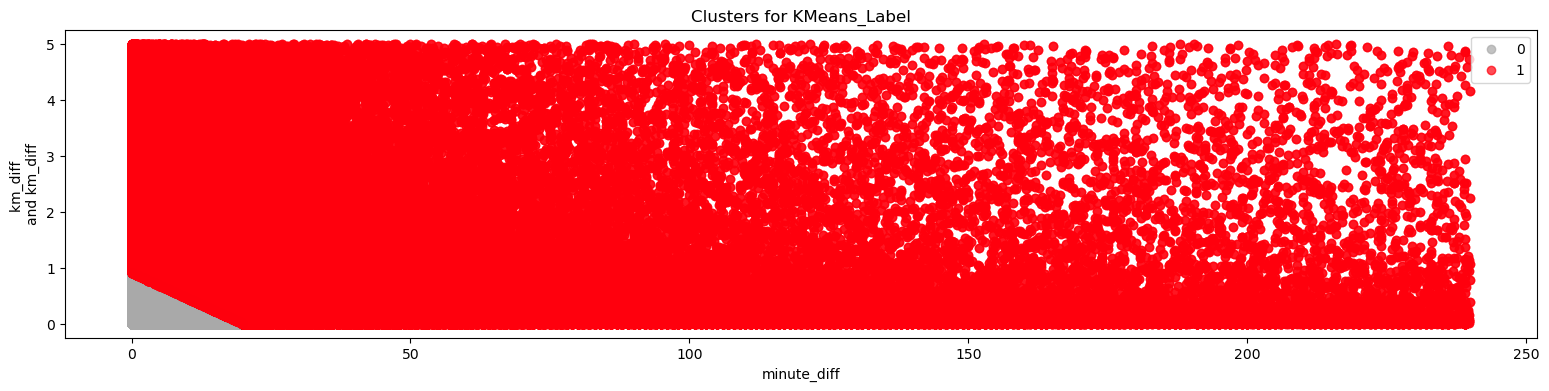

0    689958
1    135816
Name: KMeans_Label, dtype: int64

In [196]:

# scale data --choosing StandardScaler this time, might try MinMax later
sts = StandardScaler()
limited_kmeans_df_scaled = sts.fit_transform(limited_kmeans_df)

#instantiate model
limited_kmeans_model = KMeans(n_clusters = 2, max_iter = 1000, random_state = 1114)
#choosing only 2 clusters because I'm hoping to find the range of time/dist differences that indicate TOGETHER vs NOT

cluster_labels = limited_kmeans_model.fit_predict(limited_kmeans_df_scaled)
limited_kmeans_df["KMeans_Label"] = cluster_labels
cluster_overview("KMeans_Label", df = limited_kmeans_df, x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

limited_kmeans_df["KMeans_Label"].value_counts()

In [197]:
limited_kmeans_df[limited_kmeans_df["KMeans_Label"]==0].describe()

minute_diff        km_diff  KMeans_Label
count  689958.000000  689958.000000      689958.0
mean        2.832477       0.050496           0.0
std         3.450985       0.096182           0.0
min        -0.001000      -0.001000           0.0
25%         0.616667       0.000000           0.0
50%         1.450000       0.011371           0.0
75%         3.966667       0.053801           0.0
max        19.850000       0.901895           0.0

C:\Users\lisa_\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



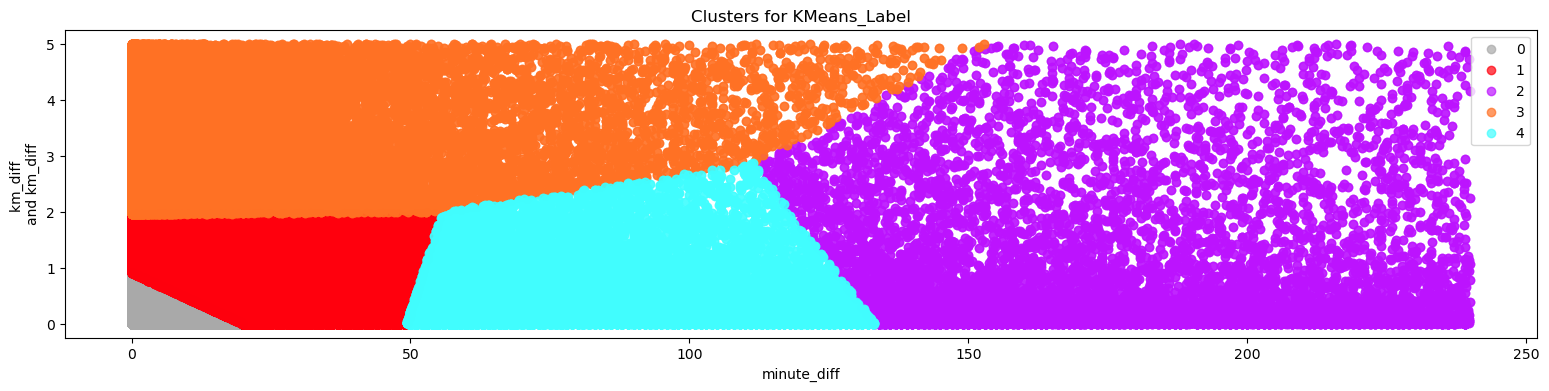

0    689958
1     80780
3     25428
4     20352
2      9256
Name: KMeans_Label, dtype: int64

In [198]:

# scale data --choosing StandardScaler this time, might try MinMax later
sts = StandardScaler()
limited_kmeans_df_scaled = sts.fit_transform(limited_kmeans_df)

#instantiate model
limited_kmeans_model = KMeans(n_clusters = 5, max_iter = 1000, random_state = 1114)
#choosing only 2 clusters because I'm hoping to find the range of time/dist differences that indicate TOGETHER vs NOT

cluster_labels = limited_kmeans_model.fit_predict(limited_kmeans_df_scaled)
limited_kmeans_df["KMeans_Label"] = cluster_labels
cluster_overview("KMeans_Label", df = limited_kmeans_df, x = "minute_diff", y_1 = "km_diff", y_2 = "km_diff")

limited_kmeans_df["KMeans_Label"].value_counts()

In [199]:
limited_kmeans_df[limited_kmeans_df["KMeans_Label"]==0].describe()

minute_diff        km_diff  KMeans_Label
count  689958.000000  689958.000000      689958.0
mean        2.832477       0.050496           0.0
std         3.450985       0.096182           0.0
min        -0.001000      -0.001000           0.0
25%         0.616667       0.000000           0.0
50%         1.450000       0.011371           0.0
75%         3.966667       0.053801           0.0
max        19.850000       0.901895           0.0